# Context for AIC (ETL + Data Preparation)

This notebook is used to calculate metrics / indicators / context data to be used on the Methodological Guide that this project aims to produce.

## 1. Import Libraries

In [28]:
# Import Libraries
import re
import logging
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
import geotable
from geopandas import GeoDataFrame
from shapely.geometry import Point
import seaborn as sns
import json
import numpy as np
import contextily as cx
import plotly.io as pio
import pingouin as pg

from sklearn import metrics
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
import scipy.sparse as sp

import statsmodels
import statsmodels.api as sm

import math

from statsmodels.stats.outliers_influence import variance_inflation_factor

pio.renderers.default='notebook'

/Users/andresilvalima/miniforge3/envs/Thesis/lib/python3.11/site-packages/osgeo/osr.py:385: FutureWarning:

Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.



## 2. Check Data

### 2.1 PT2020_Operacoes_Resumo

In [7]:
# read data
xls = pd.ExcelFile('../Data/PT2020_Resumo_PI-6.5_2023-05-03.xlsx')

In [8]:
# read data
OP_NOK = pd.read_excel(xls, 'P_6.5',dtype={'DICOFRE': str, 'DICO':str})

In [9]:
OP_NOK.head()

Código da Operação | Operation Code  \
0         CENTRO-07-2316-FEDER-000065   
1         CENTRO-09-2316-FEDER-000188   
2          NORTE-04-2316-FEDER-000276   
3          NORTE-04-2316-FEDER-000090   
4          NORTE-04-2316-FEDER-000343   

  Programa Operacional | Operational Programme  \
0      Programa Operacional Regional do Centro   
1      Programa Operacional Regional do Centro   
2       Programa Operacional Regional do Norte   
3       Programa Operacional Regional do Norte   
4       Programa Operacional Regional do Norte   

           Eixo Prioritário do PO | OP Priority Axis  \
0  07-Afirmar a sustentabilidade dos territórios ...   
1                09-Reforçar a rede urbana (CIDADES)   
2                             04-Qualidade ambiental   
3                             04-Qualidade ambiental   
4                             04-Qualidade ambiental   

   % Cofinanciamento | % EU funding  \
0                              0.85   
1                              0.85   
2                              0.85   
3                              0.85   
4                              0.85   

              Objetivo Temático | Thematic Objective  \
0  06 - Preservar e proteger o ambiente e promove...   
1  06 - Preservar e proteger o ambiente e promove...   
2  06 - Preservar e proteger o ambiente e promove...   
3  06 - Preservar e proteger o ambiente e promove...   
4  06 - Preservar e proteger o ambiente e promove...   

    Prioridade de Investimento | Investment Priority  \
0  05 - A adoção de medidas destinadas a melhorar...   
1  05 - A adoção de medidas destinadas a melhorar...   
2  05 - A adoção de medidas destinadas a melhorar...   
3  05 - A adoção de medidas destinadas a melhorar...   
4  05 - A adoção de medidas destinadas a melhorar...   

   NIF | Tax Identification Number Nome do Beneficiário | Beneficiary Name  \
0                        507011937            MUNICÍPIO DE PEDRÓGÃO GRANDE   
1                        505931192                     MUNICÍPIO DE AVEIRO   
2                        505985217                     MUNICIPIO DE VIZELA   
3                        506666018       MUNICÍPIO DE CARRAZEDA DE ANSIÃES   
4                        506753905                    MUNICÍPIO DE TAROUCA   

                   Nome da Operação | Operation Name  \
0                 Requalificação do Recinto da Feira   
1    Requalificação da Avenida Dr. Lourenço Peixinho   
2  Requalificação do Espaço Público na Rua do Cal...   
3               Requalificação da Praça do Município   
4   Regeneração da zona Ribeirinha da Ucanha - Fa...   

                                    Resumo | Summary  ...       Aviso | Call  \
0   A ação de requalificação do recinto da feira ...  ...  CENTRO-16-2016-03   
1   A Avenida caracteriza-se por uma construção d...  ...  CENTRO-16-2018-05   
2   A intervenção que se propõe na Rua João Silva...  ...   NORTE-16-2018-10   
3   A intervenção resume-sea modificação do pavim...  ...   NORTE-16-2016-16   
4   A intervenção, aliada à fase 1, visa promover...  ...   NORTE-16-2019-19   

   DICO  DICOFRE  DICO2 DICOFRE2  \
0  1013   101302  11013  1101302   
1  0105   010517  10105  1010517   
2  0314   031409  10314  1031409   
3  0403   040304  10403  1040304   
4  1820   182011  11820  1182011   

                           Concat_Concelho-Freguesia  \
0                     pedrógão grandepedrógão grande   
1   aveirounião das freguesias de glória e vera cruz   
2  vizelaunião das freguesias de tagilde e vizela...   
3           carrazeda de ansiãescarrazeda de ansiães   
4   taroucaunião das freguesias de gouviães e ucanha   

  População Concelho - Censos 2021 População Freguesia - Censos 2021  \
0                             3390                              2256   
1                            80954                             21227   
2                            23896                              3360   
3                             5490                              1706   
4      

In [10]:
OP_NOK.columns

Index(['Código da Operação | Operation Code',
       'Programa Operacional | Operational Programme',
       'Eixo Prioritário do PO | OP Priority Axis',
       '% Cofinanciamento | % EU funding',
       'Objetivo Temático | Thematic Objective',
       'Prioridade de Investimento | Investment Priority',
       'NIF | Tax Identification Number',
       'Nome do Beneficiário | Beneficiary Name',
       'Nome da Operação | Operation Name', 'Resumo | Summary',
       'Despesas Elegíveis Totais Atribuídas à Operação | Total Eligible Expenditure Allocated to the Operation\n[€ - EUR]',
       'FEEI | ESI Fund',
       'Fundo Total Aprovado | Total Aproved Fund\n[€ - EUR]',
       'Data Início | Start Date ', 'Data Fim | Finish Date ',
       'País | Country', 'NUTS II | NUTS 2', 'NUTS III | NUTS 3',
       'Concelho | Municipality', 'Freguesia | Parrish',
       'Domínio Intervenção | Category of intervention', 'Aviso | Call',
       'DICO', 'DICOFRE', 'DICO2', 'DICOFRE2', 'Concat_Concelho-Fre

In [11]:
# filter df, keep only the columns we need
OP_NOK=OP_NOK[['Código da Operação | Operation Code','Nome da Operação | Operation Name','Fundo Total Aprovado | Total Aproved Fund\n[€ - EUR]','Data Início | Start Date ', 'Data Fim | Finish Date ','NUTS II | NUTS 2','NUTS III | NUTS 3','Concelho | Municipality','Freguesia | Parrish','DICO','DICOFRE']]

In [12]:
OP_NOK.head()

Código da Operação | Operation Code  \
0         CENTRO-07-2316-FEDER-000065   
1         CENTRO-09-2316-FEDER-000188   
2          NORTE-04-2316-FEDER-000276   
3          NORTE-04-2316-FEDER-000090   
4          NORTE-04-2316-FEDER-000343   

                   Nome da Operação | Operation Name  \
0                 Requalificação do Recinto da Feira   
1    Requalificação da Avenida Dr. Lourenço Peixinho   
2  Requalificação do Espaço Público na Rua do Cal...   
3               Requalificação da Praça do Município   
4   Regeneração da zona Ribeirinha da Ucanha - Fa...   

   Fundo Total Aprovado | Total Aproved Fund\n[€ - EUR]  \
0                                           35295.84      
1                                         3546519.33      
2                                          116009.90      
3                                           59264.18      
4                                          117925.52      

  Data Início | Start Date  Data Fim | Finish Date  NUTS II | NUTS 2  \
0                2016-08-05              2017-05-08           Centro   
1                2020-07-27              2022-12-31           Centro   
2                2017-05-18              2020-05-31            Norte   
3                2017-04-26              2017-09-30            Norte   
4                2020-05-01              2022-01-31            Norte   

  NUTS III | NUTS 3 Concelho | Municipality  \
0  Região de Leiria         Pedrógão Grande   
1  Região de Aveiro                  Aveiro   
2               Ave                  Vizela   
3             Douro    Carrazeda de Ansiães   
4             Douro                 Tarouca   

                                 Freguesia | Parrish  DICO DICOFRE  
0                                    Pedrógão Grande  1013  101302  
1         União das freguesias de Glória e Vera Cruz  0105  010517  
2  União das freguesias de Tagilde e Vizela (São ...  0314  031409  
3                               Carrazeda de Ansiães  0403  040304  
4          União das freguesias de Gouviães e Ucanha  1820  182011

In [13]:
list(OP_NOK.columns)

['Código da Operação | Operation Code',
 'Nome da Operação | Operation Name',
 'Fundo Total Aprovado | Total Aproved Fund\n[€ - EUR]',
 'Data Início | Start Date ',
 'Data Fim | Finish Date ',
 'NUTS II | NUTS 2',
 'NUTS III | NUTS 3',
 'Concelho | Municipality',
 'Freguesia | Parrish',
 'DICO',
 'DICOFRE']

In [14]:
# rename columns
OP_NOK.rename(columns={'Código da Operação | Operation Code':'CODE',
                       'Nome da Operação | Operation Name':'NOME',
                       'Fundo Total Aprovado | Total Aproved Fund\n[€ - EUR]':'VALOR',
                       'Data Início | Start Date ':'INICIO',
                       'Data Fim | Finish Date ':'FIM',
                       'NUTS II | NUTS 2':'NUTSII',
                       'NUTS III | NUTS 3':'NUTSIII',
                       'Concelho | Municipality':'MUNICIPIO',
                       'Freguesia | Parrish':'FREGUESIA'}, inplace=True)

In [15]:
OP_NOK.shape

(1441, 11)

In [16]:
# drop POSEUR PROJECTS (big investments, not relevant for this analysis - total 15)
OP_NOK=OP_NOK[OP_NOK['CODE'].str.contains("POSEUR")==False]

In [17]:
OP_NOK.shape

(1426, 11)

In [18]:
OP_NOK.dtypes

CODE                 object
NOME                 object
VALOR               float64
INICIO       datetime64[ns]
FIM          datetime64[ns]
NUTSII               object
NUTSIII              object
MUNICIPIO            object
FREGUESIA            object
DICO                 object
DICOFRE              object
dtype: object

### 2.2 CAOP2022

In [19]:
# load CAOP22
CAOP22=gpd.read_file('../Data/CAOP_2022/Cont_AAD_CAOP2022.shp')

In [20]:
CAOP22.head()

DICOFRE Freguesia       Concelho Distrito              TAA  Area_T_ha  \
0  081504    Sagres  Vila do Bispo     Faro  ÁREA SECUNDÁRIA    3436.93   
1  081504    Sagres  Vila do Bispo     Faro  ÁREA SECUNDÁRIA    3436.93   
2  081504    Sagres  Vila do Bispo     Faro  ÁREA SECUNDÁRIA    3436.93   
3  081504    Sagres  Vila do Bispo     Faro  ÁREA SECUNDÁRIA    3436.93   
4  081504    Sagres  Vila do Bispo     Faro  ÁREA SECUNDÁRIA    3436.93   

   Area_EA_ha Des_Simpli                                           geometry  
0        0.04     Sagres  POLYGON ((-69674.530 -294276.294, -69681.011 -...  
1        0.17     Sagres  POLYGON ((-69645.821 -294240.694, -69657.401 -...  
2        0.20     Sagres  POLYGON ((-69720.371 -294162.995, -69715.271 -...  
3        0.09     Sagres  POLYGON ((-70031.961 -294143.877, -70041.691 -...  
4        0.39     Sagres  POLYGON ((-69800.002 -294108.296, -69796.762 -...

### 2.3 BGRI21

In [21]:
# load BGRI21
BGRI21=gpd.read_file('../Data/BGRI21_CONT/BGRI21_CONT.gpkg', layer='BGRI21_CONT')

In [22]:
BGRI21.head()

OBJECTID     BGRI2021 DT21 DTMN21 DTMNFR21 DTMNFRSEC21 SECNUM21 SSNUM21  \
0         1  16101700125   16   1610   161017   161017001      001      25   
1         2  16101900118   16   1610   161019   161019001      001      18   
2         3  16101900119   16   1610   161019   161019001      001      19   
3         4  16101900204   16   1610   161019   161019002      002      04   
4         5  16100300101   16   1610   161003   161003001      001      01   

  SECSSNUM21    SUBSECCAO  ... N_INDIVIDUOS_25_64 N_INDIVIDUOS_65_OU_MAIS  \
0      00125  16101700125  ...                0.0                     0.0   
1      00118  16101900118  ...                3.0                     1.0   
2      00119  16101900119  ...               10.0                    53.0   
3      00204  16101900204  ...                6.0                     7.0   
4      00101  16100300101  ...                0.0                     0.0   

  N_IND_ENSINO_BASICO_COMPLETO  N_IND_ENSINO_SEC_OU_POS_SEC_COMPLETO  \
0                          0.0                                   0.0   
1                          1.0                                   1.0   
2                         31.0                                   4.0   
3                          6.0                                   5.0   
4                          0.0                                   0.0   

   N_IND_ENSINO_SUPERIOR_COMPLETO  N_IND_EMPREGADOS  N_IND_REFORMADOS  \
0                             0.0               0.0               0.0   
1                             2.0               1.0               1.0   
2                             2.0               5.0              58.0   
3                             2.0               6.0               7.0   
4                             0.0               0.0               0.0   

   Shape_Length    Shape_Area  \
0   2233.574667  1.548717e+05   
1   1475.979773  6.907714e+04   
2   1310.420092  8.899950e+04   
3    456.251705  6.427454e+03   
4   6154.696498  1.163071e+06   

                                            geometry  
0  MULTIPOLYGON (((-46940.771 252330.622, -46904....  
1  MULTIPOLYGON (((-49743.698 252577.047, -49741....  
2  MULTIPOLYGON (((-50405.542 252654.352, -50374....  
3  MULTIPOLYGON (((-50454.163 252674.832, -50447....  
4  MULTIPOLYGON (((-44245.381 252435.906, -44243....  

[5 rows x 53 columns]

In [23]:
# rename columns
BGRI21.rename(columns={'DTMNFR21':'DICOFRE','DTMN21':'DICO'}, inplace=True)

In [24]:
BGRI21.columns

Index(['OBJECTID', 'BGRI2021', 'DT21', 'DICO', 'DICOFRE', 'DTMNFRSEC21',
       'SECNUM21', 'SSNUM21', 'SECSSNUM21', 'SUBSECCAO', 'NUTS1', 'NUTS2',
       'NUTS3', 'N_EDIFICIOS_CLASSICOS', 'N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ',
       'N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS',
       'N_EDIFICIOS_EXCLUSIV_RESID', 'N_EDIFICIOS_1_OU_2_PISOS',
       'N_EDIFICIOS_3_OU_MAIS_PISOS', 'N_EDIFICIOS_CONSTR_ANTES_1945',
       'N_EDIFICIOS_CONSTR_1946_1980', 'N_EDIFICIOS_CONSTR_1981_2000',
       'N_EDIFICIOS_CONSTR_2001_2010', 'N_EDIFICIOS_CONSTR_2011_2021',
       'N_EDIFICIOS_COM_NECESSIDADES_REPARACAO', 'N_ALOJAMENTOS_TOTAL',
       'N_ALOJAMENTOS_FAMILIARES', 'N_ALOJAMENTOS_FAM_CLASS_RHABITUAL',
       'N_ALOJAMENTOS_FAM_CLASS_VAGOS_OU_RESID_SECUNDARIA',
       'N_RHABITUAL_ACESSIVEL_CADEIRAS_RODAS',
       'N_RHABITUAL_COM_ESTACIONAMENTO', 'N_RHABITUAL_PROP_OCUP',
       'N_RHABITUAL_ARRENDADOS', 'N_AGREGADOS_DOMESTICOS_PRIVADOS',
       'N_ADP_1_OU_2_PESSOAS', 'N_ADP_3_OU_MAIS_PESSO

In [25]:
# group total population by DICOFRE
BGRI21_FREG=BGRI21.groupby('DICOFRE', as_index=False)["N_INDIVIDUOS"].sum()

In [26]:
# group total population by DICO
BGRI21_MUN=BGRI21.groupby('DICO', as_index=False)["N_INDIVIDUOS"].sum()

### 2.4 Manually Georreferenced Data (kmz file)

In [29]:
# load manually the manually Georreferred points
MISSING=geotable.load('../Data/GeoRef_POAT_Daniel.kmz')

In [30]:
MISSING.head()

Name  \
0  NORTE-04-2316-FEDER-000411   
1  NORTE-04-2316-FEDER-000032   
2  NORTE-05-2316-FEDER-000085   
3  NORTE-04-2316-FEDER-000282   
4  NORTE-04-2316-FEDER-000282   

                                    geometry_object      geometry_layer  \
0  POINT Z (-8.144383867172305 41.63640397730045 0)  GeoRef_POAT_Daniel   
1  POINT Z (-8.581257553766305 41.76354649212521 0)  GeoRef_POAT_Daniel   
2  POINT Z (-8.398208455061493 41.38919962084599 0)  GeoRef_POAT_Daniel   
3  POINT Z (-8.472845952957801 41.46583903867823 0)  GeoRef_POAT_Daniel   
4   POINT Z (-8.294921635289064 41.2678640530865 0)  GeoRef_POAT_Daniel   

                        geometry_proj4  
0  +proj=longlat +datum=WGS84 +no_defs  
1  +proj=longlat +datum=WGS84 +no_defs  
2  +proj=longlat +datum=WGS84 +no_defs  
3  +proj=longlat +datum=WGS84 +no_defs  
4  +proj=longlat +datum=WGS84 +no_defs

In [31]:
# delete unnecessary layer
MISSING=MISSING[MISSING['geometry_layer']!='Visita panorâmica']

In [32]:
# clean geometry object column
pattern = re.compile(r'POINT Z \((-?\d+\.\d+) (-?\d+\.\d+)')
logger = logging.getLogger(__name__)

def extract_geometry(geometry_object):
    match = pattern.search(geometry_object)
    if match:
        x, y = float(match.group(1)), float(match.group(2))
        return Point(x, y)
    else:
        logger.error(f"Error in row: {geometry_object}")
        return None

In [33]:
# apply function
MISSING['geometry_object'] = MISSING['geometry_object'].astype(str)
MISSING['geometry'] = MISSING['geometry_object'].apply(extract_geometry)


In [34]:
# drop unnecessary columns
MISSING.drop(columns=['geometry_object','geometry_layer','geometry_proj4'], inplace=True)

In [35]:
# rename columns
MISSING.rename(columns={'name':'CODE'}, inplace=True)

In [36]:
# transform into geodataframe
MISSING=GeoDataFrame(MISSING, geometry='geometry')

In [37]:
# set CRS
MISSING.set_crs(epsg=4326, inplace=True)

Name                   geometry
0     NORTE-04-2316-FEDER-000411  POINT (-8.14438 41.63640)
1     NORTE-04-2316-FEDER-000032  POINT (-8.58126 41.76355)
2     NORTE-05-2316-FEDER-000085  POINT (-8.39821 41.38920)
3     NORTE-04-2316-FEDER-000282  POINT (-8.47285 41.46584)
4     NORTE-04-2316-FEDER-000282  POINT (-8.29492 41.26786)
..                           ...                        ...
178   NORTE-05-2316-FEDER-000033  POINT (-8.68010 41.17276)
179   ALT20-04-2316-FEDER-000041  POINT (-8.21415 38.64878)
180   ALT20-04-2316-FEDER-000057  POINT (-8.21701 38.64590)
181   NORTE-04-2316-FEDER-000073  POINT (-8.64215 42.02688)
182  CENTRO-07-2316-FEDER-000177  POINT (-8.02312 40.36326)

[183 rows x 2 columns]

In [38]:
# transform CRS
MISSING.to_crs(epsg=3763, inplace=True)

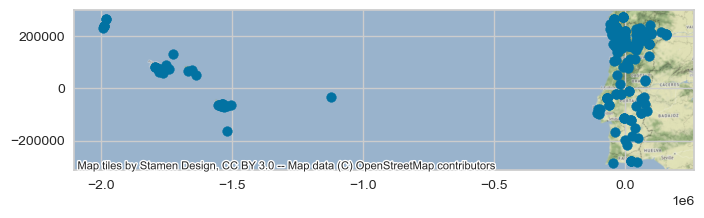

In [39]:
ax=MISSING.plot()
cx.add_basemap(ax,crs=MISSING.crs)

In [40]:
MISSING.head()

Name                       geometry
0  NORTE-04-2316-FEDER-000411    POINT (-939.486 218557.147)
1  NORTE-04-2316-FEDER-000032  POINT (-37266.686 232775.557)
2  NORTE-05-2316-FEDER-000085  POINT (-22172.541 191135.537)
3  NORTE-04-2316-FEDER-000282  POINT (-28381.712 199669.082)
4  NORTE-04-2316-FEDER-000282  POINT (-13558.929 177638.691)

### 2.5 Parrish Classification

In [41]:
# load parrish classification (Tipo de Transformação Urbana Predominante)
PARISH=pd.read_csv('../Data/TransfUrbanas_Classifica_CAOP20_2882FREGs.csv', encoding='latin',delim_whitespace=True)

In [42]:
# select relevant columns
PARISH = PARISH[['DICOFRE18','FREG18_la','TU_FINAL_name']]

In [43]:
# rename columns
PARISH.rename(columns={'DICOFRE18':'DICOFRE','FREG18_la':'FREGUESIA','TU_FINAL_name':'TU'}, inplace=True)

In [44]:
PARISH.head()

DICOFRE                                  FREGUESIA                   TU
0  010103                             Aguada de Cima   Contra-Urbanização
1  010109                                Fermentelos       Suburbanização
2  010112                         Macinhata do Vouga    Sem Classificação
3  010119                           Valongo do Vouga       Declínio Rural
4  010121  União das freguesias de Águeda e Borralha  Consolidação Urbana

## 3. Combine Data, Calculate Stats

In [45]:
# join CAOP22 info to the MISSING dataframe
INFO=gpd.sjoin(MISSING, CAOP22[['Freguesia', 'DICOFRE', 'geometry']], how='left', predicate='intersects')

In [46]:
INFO.head()

Name                       geometry  index_right  \
0  NORTE-04-2316-FEDER-000411    POINT (-939.486 218557.147)       2841.0   
1  NORTE-04-2316-FEDER-000032  POINT (-37266.686 232775.557)       2993.0   
2  NORTE-05-2316-FEDER-000085  POINT (-22172.541 191135.537)       2517.0   
3  NORTE-04-2316-FEDER-000282  POINT (-28381.712 199669.082)       2588.0   
4  NORTE-04-2316-FEDER-000282  POINT (-13558.929 177638.691)       2413.0   

                                           Freguesia DICOFRE  
0                                    Vieira do Minho  031120  
1                               Arca e Ponte de Lima  160752  
2                              Oliveira (São Mateus)  031242  
3  União das freguesias de Arnoso (Santa Maria e ...  031251  
4    União das freguesias de Cristelos, Boim e Ordem  130528

In [47]:
INFO.shape

(183, 5)

In [48]:
# drop unnecessary columns
INFO.drop(columns=['index_right'], inplace=True)

In [49]:
# rename columns
INFO.rename(columns={'Freguesia':'FREGUESIA', 'Name':'CODE'}, inplace=True)

In [50]:
INFO.head()

CODE                       geometry  \
0  NORTE-04-2316-FEDER-000411    POINT (-939.486 218557.147)   
1  NORTE-04-2316-FEDER-000032  POINT (-37266.686 232775.557)   
2  NORTE-05-2316-FEDER-000085  POINT (-22172.541 191135.537)   
3  NORTE-04-2316-FEDER-000282  POINT (-28381.712 199669.082)   
4  NORTE-04-2316-FEDER-000282  POINT (-13558.929 177638.691)   

                                           FREGUESIA DICOFRE  
0                                    Vieira do Minho  031120  
1                               Arca e Ponte de Lima  160752  
2                              Oliveira (São Mateus)  031242  
3  União das freguesias de Arnoso (Santa Maria e ...  031251  
4    União das freguesias de Cristelos, Boim e Ordem  130528

In [51]:
OP_NOK.head()

CODE  \
0  CENTRO-07-2316-FEDER-000065   
1  CENTRO-09-2316-FEDER-000188   
2   NORTE-04-2316-FEDER-000276   
3   NORTE-04-2316-FEDER-000090   
4   NORTE-04-2316-FEDER-000343   

                                                NOME       VALOR     INICIO  \
0                 Requalificação do Recinto da Feira    35295.84 2016-08-05   
1    Requalificação da Avenida Dr. Lourenço Peixinho  3546519.33 2020-07-27   
2  Requalificação do Espaço Público na Rua do Cal...   116009.90 2017-05-18   
3               Requalificação da Praça do Município    59264.18 2017-04-26   
4   Regeneração da zona Ribeirinha da Ucanha - Fa...   117925.52 2020-05-01   

         FIM  NUTSII           NUTSIII             MUNICIPIO  \
0 2017-05-08  Centro  Região de Leiria       Pedrógão Grande   
1 2022-12-31  Centro  Região de Aveiro                Aveiro   
2 2020-05-31   Norte               Ave                Vizela   
3 2017-09-30   Norte             Douro  Carrazeda de Ansiães   
4 2022-01-31   Norte             Douro               Tarouca   

                                           FREGUESIA  DICO DICOFRE  
0                                    Pedrógão Grande  1013  101302  
1         União das freguesias de Glória e Vera Cruz  0105  010517  
2  União das freguesias de Tagilde e Vizela (São ...  0314  031409  
3                               Carrazeda de Ansiães  0403  040304  
4          União das freguesias de Gouviães e Ucanha  1820  182011

In [52]:
# merge dataframes, transform OP_NOK to OP_OK (bring FREGUESIA and DECOFRE info)
OP_OK = pd.merge(OP_NOK, INFO[['CODE', 'FREGUESIA','DICOFRE']], on='CODE', how='left')
OP_OK['FREGUESIA_x'] = OP_OK['FREGUESIA_x'].where(OP_OK['FREGUESIA_x'] != 'ok', OP_OK['FREGUESIA_y'])
OP_OK = OP_OK.drop(columns=['FREGUESIA_y']).rename(columns={'FREGUESIA_x': 'FREGUESIA'})

In [53]:
OP_OK.shape

(1427, 12)

In [54]:
# filter na info for freguesia
OP_OK=OP_OK[OP_OK['FREGUESIA']!='na']

In [55]:
OP_OK.shape

(1353, 12)

In [56]:
# remove islands
OP_OK = OP_OK[(OP_OK['NUTSII'] != 'Região Autónoma dos Açores')] 
OP_OK = OP_OK[(OP_OK['NUTSII'] != 'Região Autónoma da Madeira')]

In [57]:
OP_OK.reset_index(drop=True, inplace=True)

In [58]:
OP_OK.shape

(1314, 12)

In [59]:
OP_OK.tail()

CODE  \
1309   NORTE-04-2316-FEDER-000073   
1310   NORTE-04-2316-FEDER-000452   
1311   NORTE-04-2316-FEDER-000114   
1312  CENTRO-07-2316-FEDER-000177   
1313   ALT20-04-2316-FEDER-000092   

                                                   NOME       VALOR  \
1309  Requalificação Urbana da Área Central da Cidad...   446571.63   
1310                           Cerveira Palco das Artes  2121450.25   
1311  Qualificação Urbana da Praça da República, Inc...   462885.02   
1312  Reabilitação de Edifício Municipal para Espaço...   820116.57   
1313  RECONVERSÃO DO ANTIGO EDIFICIO DO IVV PARA PAV...  4537925.80   

         INICIO        FIM    NUTSII                   NUTSIII  \
1309 2016-05-02 2018-04-30     Norte                Alto Minho   
1310 2022-03-01 2023-06-30     Norte                Alto Minho   
1311 2018-12-01 2021-07-31     Norte  Terras de Trás-os-Montes   
1312 2017-01-23 2022-12-31    Centro         Região de Coimbra   
1313 2017-11-10 2022-12-31  Alentejo           Lezíria do Tejo   

                  MUNICIPIO  \
1309                Valença   
1310  Vila Nova de Cerveira   
1311              Vila Flor   
1312                  Tábua   
1313               Almeirim   

                                              FREGUESIA  DICO DICOFRE_x  \
1309  União das freguesias de Valença, Cristelo Covo...  1608    000000   
1310  União das freguesias de Vila Nova de Cerveira ...  1610    161019   
1311           União das freguesias de Vila Flor e Nabo  0410    041023   
1312                                              Tábua  0616    000000   
1313                                           Almeirim  1403    140301   

     DICOFRE_y  
1309    160820  
1310       NaN  
1311       NaN  
1312    061614  
1313       NaN

In [60]:
# correct DICOFRE, drop and rename columns
OP_OK['DICOFRE_x'] = OP_OK['DICOFRE_x'].where(OP_OK['DICOFRE_x'] != "000000", OP_OK['DICOFRE_y'])
OP_OK = OP_OK.drop(columns=['DICOFRE_y']).rename(columns={'DICOFRE_x': 'DICOFRE'})

In [61]:
OP_OK.head()

CODE  \
0  CENTRO-07-2316-FEDER-000065   
1  CENTRO-09-2316-FEDER-000188   
2   NORTE-04-2316-FEDER-000276   
3   NORTE-04-2316-FEDER-000090   
4   NORTE-04-2316-FEDER-000343   

                                                NOME       VALOR     INICIO  \
0                 Requalificação do Recinto da Feira    35295.84 2016-08-05   
1    Requalificação da Avenida Dr. Lourenço Peixinho  3546519.33 2020-07-27   
2  Requalificação do Espaço Público na Rua do Cal...   116009.90 2017-05-18   
3               Requalificação da Praça do Município    59264.18 2017-04-26   
4   Regeneração da zona Ribeirinha da Ucanha - Fa...   117925.52 2020-05-01   

         FIM  NUTSII           NUTSIII             MUNICIPIO  \
0 2017-05-08  Centro  Região de Leiria       Pedrógão Grande   
1 2022-12-31  Centro  Região de Aveiro                Aveiro   
2 2020-05-31   Norte               Ave                Vizela   
3 2017-09-30   Norte             Douro  Carrazeda de Ansiães   
4 2022-01-31   Norte             Douro               Tarouca   

                                           FREGUESIA  DICO DICOFRE  
0                                    Pedrógão Grande  1013  101302  
1         União das freguesias de Glória e Vera Cruz  0105  010517  
2  União das freguesias de Tagilde e Vizela (São ...  0314  031409  
3                               Carrazeda de Ansiães  0403  040304  
4          União das freguesias de Gouviães e Ucanha  1820  182011

In [62]:
# merge tipo de transformação urbana predominante to the main dataframe OP_OK
OP_OK = pd.merge(OP_OK, PARISH[['DICOFRE','TU']], on='DICOFRE', how='left')

In [63]:
OP_OK.head()

CODE  \
0  CENTRO-07-2316-FEDER-000065   
1  CENTRO-09-2316-FEDER-000188   
2   NORTE-04-2316-FEDER-000276   
3   NORTE-04-2316-FEDER-000090   
4   NORTE-04-2316-FEDER-000343   

                                                NOME       VALOR     INICIO  \
0                 Requalificação do Recinto da Feira    35295.84 2016-08-05   
1    Requalificação da Avenida Dr. Lourenço Peixinho  3546519.33 2020-07-27   
2  Requalificação do Espaço Público na Rua do Cal...   116009.90 2017-05-18   
3               Requalificação da Praça do Município    59264.18 2017-04-26   
4   Regeneração da zona Ribeirinha da Ucanha - Fa...   117925.52 2020-05-01   

         FIM  NUTSII           NUTSIII             MUNICIPIO  \
0 2017-05-08  Centro  Região de Leiria       Pedrógão Grande   
1 2022-12-31  Centro  Região de Aveiro                Aveiro   
2 2020-05-31   Norte               Ave                Vizela   
3 2017-09-30   Norte             Douro  Carrazeda de Ansiães   
4 2022-01-31   Norte             Douro               Tarouca   

                                           FREGUESIA  DICO DICOFRE  \
0                                    Pedrógão Grande  1013  101302   
1         União das freguesias de Glória e Vera Cruz  0105  010517   
2  União das freguesias de Tagilde e Vizela (São ...  0314  031409   
3                               Carrazeda de Ansiães  0403  040304   
4          União das freguesias de Gouviães e Ucanha  1820  182011   

                    TU  
0       Declínio Rural  
1   Crescimento Urbano  
2       Suburbanização  
3  Consolidação Urbana  
4       Declínio Rural

In [64]:
# bring total population per parrish info to the main dataframe OP_OK
OP_OK=OP_OK.merge(BGRI21_FREG[['DICOFRE','N_INDIVIDUOS']], on='DICOFRE', how='left')

In [65]:
# rename columns
OP_OK.rename(columns={'N_INDIVIDUOS':'N_INDIVIDUOS_FREG'}, inplace=True)

In [66]:
# bring total population per municipality info to the main dataframe OP_OK
OP_OK=OP_OK.merge(BGRI21_MUN[['DICO','N_INDIVIDUOS']], on='DICO', how='left')

In [67]:
# rename columns
OP_OK.rename(columns={'N_INDIVIDUOS':'N_INDIVIDUOS_MUN'}, inplace=True)

In [68]:
OP_OK.head()

CODE  \
0  CENTRO-07-2316-FEDER-000065   
1  CENTRO-09-2316-FEDER-000188   
2   NORTE-04-2316-FEDER-000276   
3   NORTE-04-2316-FEDER-000090   
4   NORTE-04-2316-FEDER-000343   

                                                NOME       VALOR     INICIO  \
0                 Requalificação do Recinto da Feira    35295.84 2016-08-05   
1    Requalificação da Avenida Dr. Lourenço Peixinho  3546519.33 2020-07-27   
2  Requalificação do Espaço Público na Rua do Cal...   116009.90 2017-05-18   
3               Requalificação da Praça do Município    59264.18 2017-04-26   
4   Regeneração da zona Ribeirinha da Ucanha - Fa...   117925.52 2020-05-01   

         FIM  NUTSII           NUTSIII             MUNICIPIO  \
0 2017-05-08  Centro  Região de Leiria       Pedrógão Grande   
1 2022-12-31  Centro  Região de Aveiro                Aveiro   
2 2020-05-31   Norte               Ave                Vizela   
3 2017-09-30   Norte             Douro  Carrazeda de Ansiães   
4 2022-01-31   Norte             Douro               Tarouca   

                                           FREGUESIA  DICO DICOFRE  \
0                                    Pedrógão Grande  1013  101302   
1         União das freguesias de Glória e Vera Cruz  0105  010517   
2  União das freguesias de Tagilde e Vizela (São ...  0314  031409   
3                               Carrazeda de Ansiães  0403  040304   
4          União das freguesias de Gouviães e Ucanha  1820  182011   

                    TU  N_INDIVIDUOS_FREG  N_INDIVIDUOS_MUN  
0       Declínio Rural             2256.0            3390.0  
1   Crescimento Urbano            21227.0           80954.0  
2       Suburbanização             3360.0           23896.0  
3  Consolidação Urbana             1706.0            5490.0  
4       Declínio Rural              698.0            7363.0

In [69]:
# bring geometry info and create dataframe OP_FREG
OP_FREG=OP_OK.merge(CAOP22[['DICOFRE','geometry']], on='DICOFRE', how='left')

In [70]:
# create dataframe OP_FREG
OP_FREG=GeoDataFrame(OP_FREG, geometry='geometry')

In [71]:
OP_FREG.head()

CODE  \
0  CENTRO-07-2316-FEDER-000065   
1  CENTRO-09-2316-FEDER-000188   
2   NORTE-04-2316-FEDER-000276   
3   NORTE-04-2316-FEDER-000090   
4   NORTE-04-2316-FEDER-000343   

                                                NOME       VALOR     INICIO  \
0                 Requalificação do Recinto da Feira    35295.84 2016-08-05   
1    Requalificação da Avenida Dr. Lourenço Peixinho  3546519.33 2020-07-27   
2  Requalificação do Espaço Público na Rua do Cal...   116009.90 2017-05-18   
3               Requalificação da Praça do Município    59264.18 2017-04-26   
4   Regeneração da zona Ribeirinha da Ucanha - Fa...   117925.52 2020-05-01   

         FIM  NUTSII           NUTSIII             MUNICIPIO  \
0 2017-05-08  Centro  Região de Leiria       Pedrógão Grande   
1 2022-12-31  Centro  Região de Aveiro                Aveiro   
2 2020-05-31   Norte               Ave                Vizela   
3 2017-09-30   Norte             Douro  Carrazeda de Ansiães   
4 2022-01-31   Norte             Douro               Tarouca   

                                           FREGUESIA  DICO DICOFRE  \
0                                    Pedrógão Grande  1013  101302   
1         União das freguesias de Glória e Vera Cruz  0105  010517   
2  União das freguesias de Tagilde e Vizela (São ...  0314  031409   
3                               Carrazeda de Ansiães  0403  040304   
4          União das freguesias de Gouviães e Ucanha  1820  182011   

                    TU  N_INDIVIDUOS_FREG  N_INDIVIDUOS_MUN  \
0       Declínio Rural             2256.0            3390.0   
1   Crescimento Urbano            21227.0           80954.0   
2       Suburbanização             3360.0           23896.0   
3  Consolidação Urbana             1706.0            5490.0   
4       Declínio Rural              698.0            7363.0   

                                            geometry  
0  POLYGON ((-1792.641 40327.414, -1799.451 40313...  
1  POLYGON ((-44040.806 112457.327, -44022.764 11...  
2  POLYGON ((-10568.532 191703.440, -10543.163 19...  
3  POLYGON ((70875.998 177853.975, 70889.408 1778...  
4  POLYGON ((31787.872 155548.711, 31821.042 1555...

In [72]:
# add column for investment per capita per parrish
OP_FREG['INV_PC_FREG']=OP_FREG['VALOR']/OP_FREG['N_INDIVIDUOS_FREG']


In [73]:
# copy dataframe
OP_MUN=OP_FREG.copy()

In [74]:
# dissolve by DICOFRE to get municipality level
OP_MUN=OP_MUN.dissolve(by='DICOFRE', as_index=False)

In [75]:
# calculate investment per capita per municipality
OP_MUN['INV_PC_MUN']=OP_MUN['VALOR']/OP_MUN['N_INDIVIDUOS_MUN']

## 4. Visualizations and Tests

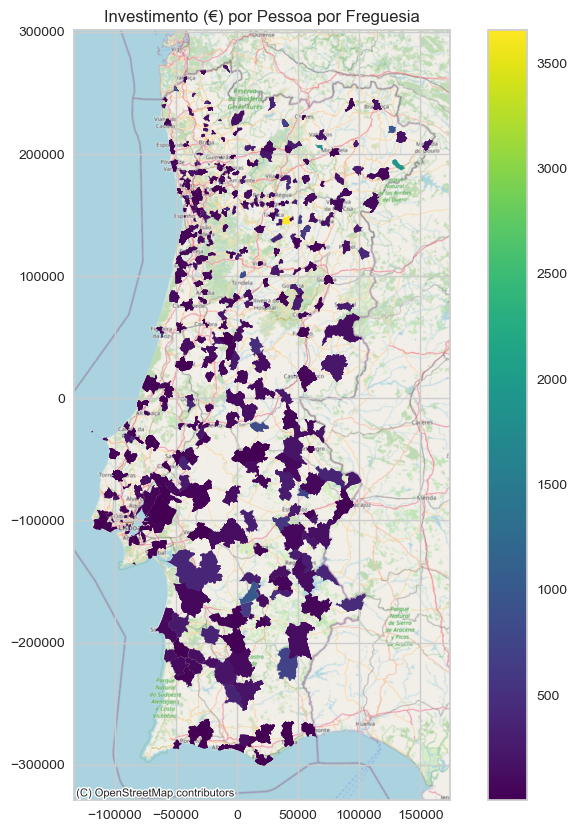

In [76]:
# visualize data
ax=OP_FREG.plot(column="INV_PC_FREG",figsize=(10,10),legend=True, cmap='viridis')
plt.title('Investimento (€) por Pessoa por Freguesia')
cx.add_basemap(ax,crs=OP_FREG.crs,source=cx.providers.OpenStreetMap.Mapnik)

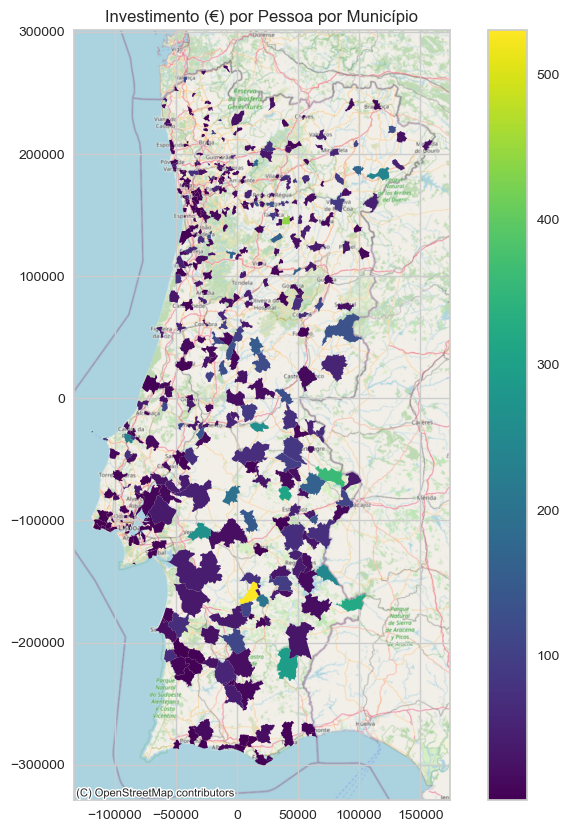

In [77]:
# visualize data
ax=OP_MUN.plot(column="INV_PC_MUN",figsize=(10,10),legend=True, cmap='viridis')
plt.title('Investimento (€) por Pessoa por Município')
cx.add_basemap(ax,crs=OP_MUN.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [78]:
# sort by investment per capita per parrish
CHECK_OP_FREG=OP_FREG.sort_values(by='INV_PC_FREG', ascending=False)

In [79]:
# filter columns
CHECK_OP_FREG=CHECK_OP_FREG[['CODE','FREGUESIA','TU','VALOR','N_INDIVIDUOS_FREG','INV_PC_FREG']]

In [80]:
CHECK_OP_FREG.head(10)

CODE  \
322   NORTE-04-2316-FEDER-000272   
1154  NORTE-04-2316-FEDER-000475   
1543  NORTE-04-2316-FEDER-000260   
1542  NORTE-05-2316-FEDER-000056   
1657  NORTE-04-2316-FEDER-000452   
18    NORTE-05-2316-FEDER-000085   
1238  ALT20-08-2316-FEDER-000015   
1001  NORTE-04-2316-FEDER-000455   
661   ALT20-08-2316-FEDER-000105   
514   ALT20-08-2316-FEDER-000068   

                                              FREGUESIA               TU  \
322                                              Leomil   Declínio Rural   
1154  União das freguesias de Brunhozinho, Castanhei...   Declínio Rural   
1543                                      Veiga de Lila   Declínio Rural   
1542  União das freguesias de Oliveira, São Paio e S...  Declínio Urbano   
1657  União das freguesias de Vila Nova de Cerveira ...   Suburbanização   
18                                Oliveira (São Mateus)  Declínio Urbano   
1238                                             Alvito   Declínio Rural   
1001                                           Argozelo   Declínio Rural   
661                            Santo António das Areias   Declínio Rural   
514            União das freguesias de Gavião e Atalaia   Declínio Rural   

            VALOR  N_INDIVIDUOS_FREG  INV_PC_FREG  
322    4134005.73             1131.0  3655.177480  
1154    410474.10              216.0  1900.343056  
1543    421027.39              233.0  1806.984506  
1542  10360462.84             7830.0  1323.175331  
1657   2121450.25             1780.0  1191.825983  
18     2772960.08             2418.0  1146.799041  
1238   1209467.00             1196.0  1011.260033  
1001    530527.47              560.0   947.370482  
661     849219.56              961.0   883.683205  
514    1257190.36             1501.0   837.568528

In [81]:
# sort by investment per capita per municipality
CHECK_OP_MUN=OP_MUN.sort_values(by='INV_PC_MUN', ascending=False)

In [82]:
# filter columns
CHECK_OP_MUN=CHECK_OP_MUN[['CODE','MUNICIPIO','TU','VALOR','N_INDIVIDUOS_MUN','INV_PC_MUN']]

In [83]:
CHECK_OP_MUN.head(10)

CODE          MUNICIPIO                   TU  \
30   ALT20-08-2316-FEDER-000015             Alvito       Declínio Rural   
374  NORTE-04-2316-FEDER-000272  Moimenta da Beira       Declínio Rural   
226  ALT20-08-2316-FEDER-000095          Arronches       Declínio Rural   
31   ALT20-08-2316-FEDER-000025          Barrancos       Declínio Rural   
244  ALT20-08-2316-FEDER-000091             Sousel       Declínio Rural   
40   ALT20-08-2316-FEDER-000036            Mértola       Declínio Rural   
144  ALT20-04-2316-FEDER-000135       Vendas Novas  Consolidação Urbana   
236  ALT20-08-2316-FEDER-000071             Gavião       Declínio Rural   
135  ALT20-08-2316-FEDER-000003             Mourão       Declínio Rural   
88   NORTE-04-2316-FEDER-000198          Mogadouro       Declínio Rural   

          VALOR  N_INDIVIDUOS_MUN  INV_PC_MUN  
30   1209467.00            2280.0  530.467982  
374  4134005.73            9410.0  439.320481  
226  1000000.00            2789.0  358.551452  
31    461116.51            1438.0  320.665167  
244  1350000.00            4360.0  309.633028  
40   1821300.00            6206.0  293.474057  
144  3005289.62           11245.0  267.255635  
236   892881.44            3394.0  263.076441  
135   584235.67            2351.0  248.505177  
88   1987218.28            8301.0  239.395046

In [84]:
# kruskal wallis test for parrish dataset
pg.kruskal(data=OP_FREG, dv='INV_PC_FREG', between='TU')

Source  ddof1           H         p-unc
Kruskal     TU      6  435.309682  7.115427e-91

In [85]:
# kruskal wallis test for municipality dataset
pg.kruskal(data=OP_FREG, dv='VALOR', between='TU')

Source  ddof1          H         p-unc
Kruskal     TU      6  51.845343  2.003235e-09

In [86]:
# pairwise test for parrish dataset
pg.pairwise_tests(dv='INV_PC_FREG', between='TU', data=OP_FREG, parametric=False).round(3)

Contrast                    A                   B  Paired  Parametric  \
0        TU  Consolidação Urbana  Contra-Urbanização   False       False   
1        TU  Consolidação Urbana  Crescimento Urbano   False       False   
2        TU  Consolidação Urbana      Declínio Rural   False       False   
3        TU  Consolidação Urbana     Declínio Urbano   False       False   
4        TU  Consolidação Urbana   Sem Classificação   False       False   
5        TU  Consolidação Urbana      Suburbanização   False       False   
6        TU   Contra-Urbanização  Crescimento Urbano   False       False   
7        TU   Contra-Urbanização      Declínio Rural   False       False   
8        TU   Contra-Urbanização     Declínio Urbano   False       False   
9        TU   Contra-Urbanização   Sem Classificação   False       False   
10       TU   Contra-Urbanização      Suburbanização   False       False   
11       TU   Crescimento Urbano      Declínio Rural   False       False   
12       TU   Crescimento Urbano     Declínio Urbano   False       False   
13       TU   Crescimento Urbano   Sem Classificação   False       False   
14       TU   Crescimento Urbano      Suburbanização   False       False   
15       TU       Declínio Rural     Declínio Urbano   False       False   
16       TU       Declínio Rural   Sem Classificação   False       False   
17       TU       Declínio Rural      Suburbanização   False       False   
18       TU      Declínio Urbano   Sem Classificação   False       False   
19       TU      Declínio Urbano      Suburbanização   False       False   
20       TU    Sem Classificação      Suburbanização   False       False   

       U-val alternative  p-unc  hedges  
0    18328.0   two-sided  0.000  -0.681  
1   123247.0   two-sided  0.000   0.254  
2    26016.0   two-sided  0.000  -0.807  
3    14995.0   two-sided  0.000  -0.664  
4    21659.0   two-sided  0.000  -0.623  
5    28321.0   two-sided  0.000  -0.459  
6    34639.0   two-sided  0.000   0.997  
7    11748.0   two-sided  0.000  -0.348  
8     5476.0   two-sided  0.043  -0.072  
9     8801.0   two-sided  0.646   0.050  
10   10521.0   two-sided  0.030   0.111  
11   11029.0   two-sided  0.000  -0.818  
12    6722.0   two-sided  0.000  -0.832  
13    9178.0   two-sided  0.000  -0.937  
14   12222.0   two-sided  0.000  -0.674  
15   14064.0   two-sided  0.000   0.276  
16   23630.0   two-sided  0.000   0.379  
17   27378.0   two-sided  0.000   0.408  
18    4734.0   two-sided  0.075   0.111  
19    5777.0   two-sided  0.753   0.152  
20   12170.0   two-sided  0.059   0.071

In [87]:
# pairwise test for municipality dataset
pg.pairwise_tests(dv='VALOR', between='TU', data=OP_FREG, parametric=False).round(3)

Contrast                    A                   B  Paired  Parametric  \
0        TU  Consolidação Urbana  Contra-Urbanização   False       False   
1        TU  Consolidação Urbana  Crescimento Urbano   False       False   
2        TU  Consolidação Urbana      Declínio Rural   False       False   
3        TU  Consolidação Urbana     Declínio Urbano   False       False   
4        TU  Consolidação Urbana   Sem Classificação   False       False   
5        TU  Consolidação Urbana      Suburbanização   False       False   
6        TU   Contra-Urbanização  Crescimento Urbano   False       False   
7        TU   Contra-Urbanização      Declínio Rural   False       False   
8        TU   Contra-Urbanização     Declínio Urbano   False       False   
9        TU   Contra-Urbanização   Sem Classificação   False       False   
10       TU   Contra-Urbanização      Suburbanização   False       False   
11       TU   Crescimento Urbano      Declínio Rural   False       False   
12       TU   Crescimento Urbano     Declínio Urbano   False       False   
13       TU   Crescimento Urbano   Sem Classificação   False       False   
14       TU   Crescimento Urbano      Suburbanização   False       False   
15       TU       Declínio Rural     Declínio Urbano   False       False   
16       TU       Declínio Rural   Sem Classificação   False       False   
17       TU       Declínio Rural      Suburbanização   False       False   
18       TU      Declínio Urbano   Sem Classificação   False       False   
19       TU      Declínio Urbano      Suburbanização   False       False   
20       TU    Sem Classificação      Suburbanização   False       False   

       U-val alternative  p-unc  hedges  
0    39262.0   two-sided  0.002   0.330  
1   103980.0   two-sided  0.144  -0.029  
2    78629.5   two-sided  0.035   0.219  
3    14152.0   two-sided  0.000  -0.816  
4    42128.0   two-sided  0.191   0.125  
5    40863.0   two-sided  0.577  -0.075  
6    19454.0   two-sided  0.155  -0.306  
7    14248.0   two-sided  0.174  -0.149  
8     2210.0   two-sided  0.000  -0.623  
9     7634.0   two-sided  0.147  -0.247  
10    7065.0   two-sided  0.001  -0.396  
11   46302.0   two-sided  0.944   0.220  
12    7981.0   two-sided  0.000  -0.660  
13   24575.0   two-sided  0.663   0.133  
14   23170.5   two-sided  0.012  -0.038  
15    5490.5   two-sided  0.000  -0.745  
16   18007.0   two-sided  0.684  -0.101  
17   16980.0   two-sided  0.017  -0.296  
18    7964.5   two-sided  0.000   0.578  
19    7952.0   two-sided  0.000   0.504  
20    9499.0   two-sided  0.076  -0.189

In [88]:
# filter extreme outliers
OP_FREG_NO_OUTLIER=OP_FREG[OP_FREG['INV_PC_FREG']<OP_FREG['INV_PC_FREG'].quantile(0.999)]

In [89]:
# visualize data
fig = px.box(OP_FREG_NO_OUTLIER,
             y="INV_PC_FREG", 
             x="TU", 
             points="all",
             color="TU")

fig.update_layout(width=1200, height=400,
    yaxis_title='Valor Total Investido (€ / Per Capita)',
    xaxis_title='Processo de Transformação Urbana Dominante')

fig.show()

In [90]:
# filter extreme outliers
OP_FREG_NO_OUTLIER=OP_FREG[OP_FREG['VALOR']<OP_FREG['VALOR'].quantile(0.999)]

In [91]:
# visualize data
fig = px.box(OP_FREG_NO_OUTLIER, 
             y="VALOR", 
             x="TU", 
             points="all",
             color="TU")

fig.update_layout(width=1200, height=400,
    yaxis_title='Valor Total Investido (€)',
    xaxis_title='Processo de Transformação Urbana Dominante')

fig.show()

In [92]:
# get a pivot table with mean values for investment per capita per type of parrish (TU)
A=pd.pivot_table(OP_FREG, values=['INV_PC_FREG','VALOR'], index=['TU'], aggfunc=np.mean, sort=True).round(0)
A.sort_values(by='INV_PC_FREG', ascending=False)

INV_PC_FREG      VALOR
TU                                         
Declínio Rural             209.0   402691.0
Declínio Urbano            126.0  1436961.0
Contra-Urbanização         114.0   339402.0
Sem Classificação          109.0   451381.0
Suburbanização              99.0   571043.0
Consolidação Urbana         54.0   524228.0
Crescimento Urbano          35.0   543394.0

In [93]:
# filter for Aveiro
AVEIRO=OP_FREG[OP_FREG['DICOFRE']=='010517']

In [94]:
# filter columns
AVEIRO=AVEIRO[['CODE','NOME','VALOR','INICIO','FIM','MUNICIPIO']]

In [95]:
# sort by finish date (ascending)
AVEIRO.sort_values(by='FIM', ascending=True)

CODE  \
567  CENTRO-09-2316-FEDER-000026   
547  CENTRO-09-2316-FEDER-000055   
68   CENTRO-09-2316-FEDER-000191   
720  CENTRO-09-2316-FEDER-000110   
721  CENTRO-09-2316-FEDER-000109   
564  CENTRO-09-2316-FEDER-000159   
1    CENTRO-09-2316-FEDER-000188   
565  CENTRO-09-2316-FEDER-000237   
80   CENTRO-09-2316-FEDER-000192   

                                                  NOME       VALOR     INICIO  \
567  Requalificação da Rua de José Estêvão e Ruas A...   180266.97 2016-06-20   
547                  Qualificação da Ponte de São João   599997.25 2016-12-30   
68                         Qualificação da Rua da Pega  1450895.96 2019-10-08   
720           Reabilitação do edifício Fernando Távora  1262251.73 2017-05-15   
721  Reabilitação do edifício da antiga Estação de ...   634320.13 2017-11-17   
564  Reabilitação das Ruas do Gravito, Carmo e Almi...   467959.34 2019-06-15   
1      Requalificação da Avenida Dr. Lourenço Peixinho  3546519.33 2020-07-27   
565        Requalificação da Praça Dr. Ferreira Soares   128272.10 2021-06-08   
80   Requalificação do Largo do Rossio e área envol...  2051423.31 2021-06-01   

           FIM MUNICIPIO  
567 2017-03-31    Aveiro  
547 2018-05-31    Aveiro  
68  2021-06-30    Aveiro  
720 2021-08-31    Aveiro  
721 2021-08-31    Aveiro  
564 2022-03-31    Aveiro  
1   2022-12-31    Aveiro  
565 2022-12-31    Aveiro  
80  2023-03-31    Aveiro

In [96]:
# filter for Ilhavo
ILHAVO=OP_FREG[(OP_FREG['DICOFRE']=='011008') & (OP_FREG['DICO']=='0110')]
# filter columns
ILHAVO=ILHAVO[['CODE','NOME','VALOR','INICIO','FIM','MUNICIPIO']]
# sort by finish date (ascending)
ILHAVO.sort_values(by='FIM', ascending=True)

CODE  \
1303  CENTRO-09-2316-FEDER-000025   
584   CENTRO-09-2316-FEDER-000084   
1338  CENTRO-09-2316-FEDER-000112   
726   CENTRO-09-2316-FEDER-000176   
1337  CENTRO-09-2316-FEDER-000120   
1631  CENTRO-09-2316-FEDER-000092   
1210  CENTRO-09-2316-FEDER-000177   
1339  CENTRO-09-2316-FEDER-000121   

                                                   NOME       VALOR  \
1303                   Reabilitação Rua Dr. Samuel Maia    56243.59   
584                Requalificação da Rua Carlos Marnoto   112877.22   
1338            Requalificação do Bairro dos Pescadores   445444.50   
726                 REQUALIFICAÇÃO DO PARQUE DA MALHADA   480509.36   
1337  Requalificação dos Acessos e Zona Verde Junto ...   275809.86   
1631  Centro para a Valorização e Interpretação da R...  1190575.34   
1210  REQUALIFICAÇÃO DO ESPAÇO URBANO CENTRAL / JARD...  1276225.94   
1339            Requalificação da Rua João Carlos Gomes   190474.74   

         INICIO        FIM MUNICIPIO  
1303 2016-11-28 2017-05-31    Ílhavo  
584  2019-01-07 2020-03-28    Ílhavo  
1338 2020-04-14 2021-07-13    Ílhavo  
726  2020-11-09 2021-12-31    Ílhavo  
1337 2020-02-17 2021-12-31    Ílhavo  
1631 2019-05-02 2021-12-31    Ílhavo  
1210 2020-04-30 2022-03-04    Ílhavo  
1339 2020-08-03 2022-03-31    Ílhavo

## 5. Clusters_new Tests (Calinski-Harabasz index and Davies-Bouldin index)

### 5.1 Aveiro-Ílhavo (PCA based)

#### 5.1.1 Preparation (PCA)

In [97]:
bgri_cluster = pd.read_pickle('../Data/piclo_bgri.piclo')

In [98]:
bgri_cluster.drop(columns=['LUGAR_NOME'], inplace=True)

In [99]:
# drop rows with NaNs
bgri_cluster.drop([1024, 1025, 514, 8, 9, 520, 1548, 525, 1038, 527, 16, 17, 18, 528, 532, 1039, 1022, 
                   1551, 536, 538, 539, 1050, 1051, 30, 543, 1565, 1568, 1059, 548, 37, 549, 550, 551, 
                   553, 1571, 555, 560, 562, 1075, 564, 565, 1587, 571, 60, 1084, 574, 63, 1601, 66, 
                   581, 70, 582, 583, 1606, 74, 75, 76, 589, 591, 1104, 596, 1109, 1111, 1625, 1626, 
                   604, 1629, 94, 96, 98, 102, 614, 615, 105, 1127, 1130, 1640, 1133, 1642, 1643, 1644, 
                   1645, 627, 628, 1140, 1653, 1659, 636, 639, 128, 640, 641, 646, 1162, 139, 140, 1165, 
                   654, 656, 657, 658, 1170, 148, 661, 150, 1174, 664, 1680, 666, 1682, 1180, 672, 1699, 
                   676, 165, 166, 1702, 1193, 682, 1707, 1708, 686, 1711, 688, 1200, 690, 1205, 694, 1206, 
                   184, 185, 697, 1208, 1215, 194, 1219, 1220, 1224, 1226, 204, 205, 206, 207, 718, 1745, 
                   1234, 1750, 728, 1241, 1244, 222, 1246, 736, 1248, 1760, 742, 1254, 1256, 1766, 747, 
                   236, 237, 748, 1774, 241, 753, 1265, 1777, 757, 758, 247, 1270, 761, 1781, 1786, 1787, 
                   1791, 769, 776, 270, 1295, 272, 275, 792, 1304, 1305, 1306, 1307, 287, 288, 800, 1311, 
                   1824, 1825, 805, 806, 807, 1318, 809, 1323, 301, 815, 305, 1332, 316, 317, 318, 319, 
                   1344, 322, 323, 1346, 838, 839, 1355, 1358, 847, 340, 1367, 345, 857, 859, 1369, 862, 
                   863, 353, 866, 1383, 361, 880, 881, 371, 375, 376, 1399, 1403, 892, 893, 385, 903, 906, 
                   909, 911, 1425, 1429, 406, 918, 920, 409, 410, 412, 413, 414, 1441, 418, 931, 421, 424, 
                   940, 1452, 432, 1458, 952, 441, 446, 960, 1472, 964, 454, 966, 968, 969, 970, 971, 972, 
                   973, 974, 975, 976, 977, 979, 980, 984, 985, 988, 990, 991, 993, 994, 996, 998, 999, 
                   488, 1005, 494, 1010, 505, 507, 510], axis=0, inplace=True)

In [100]:
bgri_cluster['FREGUESIA2'] = bgri_cluster['FREGUESIA'].astype(str).str[:6]

In [101]:
bgri_cluster.drop(columns=['FREGUESIA'], inplace=True)
bgri_cluster.rename(columns={'FREGUESIA2':'FREGUESIA'}, inplace=True)

In [102]:
# sabemos que N_EDIFICIOS_CLASSICOS = N_EDIFICIOS_CLASSICOS_ISOLADOS + N_EDIFICIOS_CLASSICOS_GEMIN + N_EDIFICIOS_CLASSICOS_EMBANDA + 
# + N_EDIFICIOS_CLASSICOS_3OUMAIS + N_EDIFICIOS_CLASSICOS_OUTROS

# drop possivel - N_EDIFICIOS_CLASSICOS_OUTROS (para não dar 100%)

bgri_cluster['PER_EDIFICIOS_CLASSICOS_ISOLADOS']=bgri_cluster['N_EDIFICIOS_CLASSICOS_ISOLADOS']/bgri_cluster['N_EDIFICIOS_CLASSICOS']
bgri_cluster['PER_EDIFICIOS_CLASSICOS_GEMIN']=bgri_cluster['N_EDIFICIOS_CLASSICOS_GEMIN']/bgri_cluster['N_EDIFICIOS_CLASSICOS']
bgri_cluster['PER_EDIFICIOS_CLASSICOS_EMBANDA']=bgri_cluster['N_EDIFICIOS_CLASSICOS_EMBANDA']/bgri_cluster['N_EDIFICIOS_CLASSICOS']
bgri_cluster['PER_EDIFICIOS_CLASSICOS_1OU2']=bgri_cluster['N_EDIFICIOS_CLASSICOS_1OU2']/bgri_cluster['N_EDIFICIOS_CLASSICOS']
bgri_cluster['PER_EDIFICIOS_CLASSICOS_3OUMAIS']=bgri_cluster['N_EDIFICIOS_CLASSICOS_3OUMAIS']/bgri_cluster['N_EDIFICIOS_CLASSICOS']
bgri_cluster['PER_EDIFICIOS_CLASSICOS_OUTROS']=bgri_cluster['N_EDIFICIOS_CLASSICOS_OUTROS']/bgri_cluster['N_EDIFICIOS_CLASSICOS']

bgri_cluster.drop(['N_EDIFICIOS_CLASSICOS','N_EDIFICIOS_CLASSICOS_1OU2', 'N_EDIFICIOS_CLASSICOS_ISOLADOS','N_EDIFICIOS_CLASSICOS_GEMIN',
                   'N_EDIFICIOS_CLASSICOS_EMBANDA','N_EDIFICIOS_CLASSICOS_3OUMAIS','N_EDIFICIOS_CLASSICOS_OUTROS'], axis=1, inplace=True)

In [103]:
# sabemos que N_EDIFICIOS_EXCLUSIV_RESID + N_EDIFICIOS_PRINCIPAL_RESID + N_EDIFICIOS_PRINCIP_NAO_RESID =
# = N_EDIFICIOS_1OU2_PISOS + N_EDIFICIOS_3OU4_PISOS + N_EDIFICIOS_5OU_MAIS_PISOS

# drop possivel - PER_EDIFICIOS_5OU_MAIS_PISOS (para não dar 100%)

bgri_cluster['total_temp']=bgri_cluster['N_EDIFICIOS_EXCLUSIV_RESID']+bgri_cluster['N_EDIFICIOS_PRINCIPAL_RESID']+bgri_cluster['N_EDIFICIOS_PRINCIP_NAO_RESID']

bgri_cluster['PER_EDIFICIOS_EXCLUSIV_RESID']=bgri_cluster['N_EDIFICIOS_EXCLUSIV_RESID']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_PRINCIPAL_RESID']=bgri_cluster['N_EDIFICIOS_PRINCIPAL_RESID']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_PRINCIP_NAO_RESID']=bgri_cluster['N_EDIFICIOS_PRINCIP_NAO_RESID']/bgri_cluster['total_temp']

bgri_cluster['PER_EDIFICIOS_1OU2_PISOS']=bgri_cluster['N_EDIFICIOS_1OU2_PISOS']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_3OU4_PISOS']=bgri_cluster['N_EDIFICIOS_3OU4_PISOS']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_5OU_MAIS_PISOS']=bgri_cluster['N_EDIFICIOS_5OU_MAIS_PISOS']/bgri_cluster['total_temp']

bgri_cluster.drop(['total_temp','N_EDIFICIOS_EXCLUSIV_RESID','N_EDIFICIOS_PRINCIPAL_RESID','N_EDIFICIOS_PRINCIP_NAO_RESID',
                   'N_EDIFICIOS_1OU2_PISOS','N_EDIFICIOS_3OU4_PISOS','N_EDIFICIOS_5OU_MAIS_PISOS'], axis=1, inplace=True)

In [104]:
# conversão dos indicadores do ano de construção em percentagens do total de casas

# drop possivel - N_EDIFICIOS_CONSTR_2006A2011 (para não dar 100%)

bgri_cluster['total_temp']=bgri_cluster['N_EDIFICIOS_CONSTR_ANTES_1919']+bgri_cluster['N_EDIFICIOS_CONSTR_1919A1945']+bgri_cluster['N_EDIFICIOS_CONSTR_1946A1960']+bgri_cluster['N_EDIFICIOS_CONSTR_1961A1970']+bgri_cluster['N_EDIFICIOS_CONSTR_1971A1980']+bgri_cluster['N_EDIFICIOS_CONSTR_1981A1990']+bgri_cluster['N_EDIFICIOS_CONSTR_1991A1995']+bgri_cluster['N_EDIFICIOS_CONSTR_1996A2000']+bgri_cluster['N_EDIFICIOS_CONSTR_2001A2005']+bgri_cluster['N_EDIFICIOS_CONSTR_2006A2011']

bgri_cluster['PER_EDIFICIOS_CONSTR_ANTES_1919']=bgri_cluster['N_EDIFICIOS_CONSTR_ANTES_1919']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1919A1945']=bgri_cluster['N_EDIFICIOS_CONSTR_1919A1945']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1946A1960']=bgri_cluster['N_EDIFICIOS_CONSTR_1946A1960']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1961A1970']=bgri_cluster['N_EDIFICIOS_CONSTR_1961A1970']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1971A1980']=bgri_cluster['N_EDIFICIOS_CONSTR_1971A1980']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1981A1990']=bgri_cluster['N_EDIFICIOS_CONSTR_1981A1990']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1991A1995']=bgri_cluster['N_EDIFICIOS_CONSTR_1991A1995']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1996A2000']=bgri_cluster['N_EDIFICIOS_CONSTR_1996A2000']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_2001A2005']=bgri_cluster['N_EDIFICIOS_CONSTR_2001A2005']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_2006A2011']=bgri_cluster['N_EDIFICIOS_CONSTR_2006A2011']/bgri_cluster['total_temp']

bgri_cluster.drop(['total_temp','N_EDIFICIOS_CONSTR_ANTES_1919','N_EDIFICIOS_CONSTR_1919A1945','N_EDIFICIOS_CONSTR_1946A1960','N_EDIFICIOS_CONSTR_1961A1970','N_EDIFICIOS_CONSTR_1971A1980','N_EDIFICIOS_CONSTR_1981A1990','N_EDIFICIOS_CONSTR_1991A1995','N_EDIFICIOS_CONSTR_1996A2000','N_EDIFICIOS_CONSTR_2001A2005','N_EDIFICIOS_CONSTR_2006A2011'], axis=1, inplace=True)

In [105]:
# vamos agora droppar variáveis que decidimos não usar, por acreditarmos que não "informam" o modelo

bgri_cluster.drop(['N_EDIFICIOS_ESTRUT_BETAO','N_EDIFICIOS_ESTRUT_COM_PLACA','N_EDIFICIOS_ESTRUT_SEM_PLACA','N_EDIFICIOS_ESTRUT_ADOBE_PEDRA','N_EDIFICIOS_ESTRUT_OUTRA'], axis=1, inplace=True)

In [106]:
# "Cluster" de Variáveis em análise: N_ALOJAMENTOS, N_ALOJAMENTOS_FAM_CLASSICOS, N_ALOJAMENTOS_FAM_N_CLASSICOS, N_ALOJAMENTOS_COLECTIVOS, N_CLASSICOS_RES_HABITUAL, N_ALOJAMENTOS_RES_HABITUAL, N_ALOJAMENTOS_VAGOS
# Após análise (à parte), definiu-se que toda a informação destas variáveis está contida nos seguintes percentuais:

bgri_cluster['PER_ALOJAMENTOS_FAM_CLASSICOS']=bgri_cluster['N_ALOJAMENTOS_FAM_CLASSICOS']/bgri_cluster['N_ALOJAMENTOS']
bgri_cluster['PER_ALOJAMENTOS_FAM_N_CLASSICOS']=bgri_cluster['N_ALOJAMENTOS_FAM_N_CLASSICOS']/bgri_cluster['N_ALOJAMENTOS']
bgri_cluster['PER_ALOJAMENTOS_COLECTIVOS']=bgri_cluster['N_ALOJAMENTOS_COLECTIVOS']/bgri_cluster['N_ALOJAMENTOS']
bgri_cluster['PER_CLASSICOS_RES_HABITUAL']=bgri_cluster['N_CLASSICOS_RES_HABITUAL']/bgri_cluster['N_ALOJAMENTOS']
bgri_cluster['PER_ALOJAMENTOS_RES_HABITUAL']=bgri_cluster['N_ALOJAMENTOS_RES_HABITUAL']/bgri_cluster['N_ALOJAMENTOS']
bgri_cluster['PER_ALOJAMENTOS_VAGOS']=bgri_cluster['N_ALOJAMENTOS_VAGOS']/bgri_cluster['N_ALOJAMENTOS']
bgri_cluster['PER_ALOJAMENTOS_FAMILIARES']=bgri_cluster['N_ALOJAMENTOS_FAMILIARES']/bgri_cluster['N_ALOJAMENTOS']

bgri_cluster.drop(['N_ALOJAMENTOS', 'N_ALOJAMENTOS_FAM_CLASSICOS', 'N_ALOJAMENTOS_FAM_N_CLASSICOS', 'N_ALOJAMENTOS_COLECTIVOS', 'N_CLASSICOS_RES_HABITUAL', 'N_ALOJAMENTOS_RES_HABITUAL', 'N_ALOJAMENTOS_VAGOS','N_ALOJAMENTOS_FAMILIARES'], axis=1, inplace=True)

In [107]:
# vamos droppar as seguintes variáveis 'N_RES_HABITUAL_COM_AGUA','N_RES_HABITUAL_COM_RETRETE','N_RES_HABITUAL_COM_ESGOTOS','N_RES_HABITUAL_COM_BANHO'

bgri_cluster.drop(['N_RES_HABITUAL_COM_AGUA','N_RES_HABITUAL_COM_RETRETE','N_RES_HABITUAL_COM_ESGOTOS','N_RES_HABITUAL_COM_BANHO'], axis=1, inplace=True)

In [108]:
# Próximo Cluster de 'N_RES_HABITUAL_AREA_50', 'N_RES_HABITUAL_AREA_50_100', 'N_RES_HABITUAL_AREA_100_200', 'N_RES_HABITUAL_AREA_200'

bgri_cluster['temp_total']=bgri_cluster['N_RES_HABITUAL_AREA_50']+bgri_cluster['N_RES_HABITUAL_AREA_50_100']+bgri_cluster['N_RES_HABITUAL_AREA_100_200']+bgri_cluster['N_RES_HABITUAL_AREA_200']

bgri_cluster['PER_RES_HABITUAL_AREA_50']=bgri_cluster['N_RES_HABITUAL_AREA_50']/bgri_cluster['temp_total']
bgri_cluster['PER_RES_HABITUAL_AREA_50_100']=bgri_cluster['N_RES_HABITUAL_AREA_50_100']/bgri_cluster['temp_total']
bgri_cluster['PER_RES_HABITUAL_AREA_100_200']=bgri_cluster['N_RES_HABITUAL_AREA_100_200']/bgri_cluster['temp_total']
bgri_cluster['PER_RES_HABITUAL_AREA_200']=bgri_cluster['N_RES_HABITUAL_AREA_200']/bgri_cluster['temp_total']

bgri_cluster.drop(['temp_total','N_RES_HABITUAL_AREA_50', 'N_RES_HABITUAL_AREA_50_100', 'N_RES_HABITUAL_AREA_100_200', 'N_RES_HABITUAL_AREA_200'], axis=1, inplace=True)

In [109]:
# Próximo Cluster de 'N_RES_HABITUAL_1_2_DIV','N_RES_HABITUAL_3_4_DIV','N_RES_HABITUAL_ESTAC_1','N_RES_HABITUAL_ESTAC_2','N_RES_HABITUAL_ESTAC_3','N_RES_HABITUAL_PROP_OCUP','N_RES_HABITUAL_ARREND'
# Não fui capaz de encontrar relação entre variáveis (os totais não batem certo), pelo que serão criados 3 subtotais e as variáveis serão percentagens desses subtotais

bgri_cluster['temp_total1']=bgri_cluster['N_RES_HABITUAL_1_2_DIV']+bgri_cluster['N_RES_HABITUAL_3_4_DIV']
bgri_cluster['temp_total2']=bgri_cluster['N_RES_HABITUAL_ESTAC_1']+bgri_cluster['N_RES_HABITUAL_ESTAC_2']+bgri_cluster['N_RES_HABITUAL_ESTAC_3']
bgri_cluster['temp_total3']=bgri_cluster['N_RES_HABITUAL_PROP_OCUP']+bgri_cluster['N_RES_HABITUAL_ARREND']

bgri_cluster['PER_RES_HABITUAL_1_2_DIV']=bgri_cluster['N_RES_HABITUAL_1_2_DIV']/bgri_cluster['temp_total1']
bgri_cluster['PER_RES_HABITUAL_3_4_DIV']=bgri_cluster['N_RES_HABITUAL_3_4_DIV']/bgri_cluster['temp_total1']
bgri_cluster['PER_RES_HABITUAL_ESTAC_1']=bgri_cluster['N_RES_HABITUAL_ESTAC_1']/bgri_cluster['temp_total2']
bgri_cluster['PER_RES_HABITUAL_ESTAC_2']=bgri_cluster['N_RES_HABITUAL_ESTAC_2']/bgri_cluster['temp_total2']
bgri_cluster['PER_RES_HABITUAL_ESTAC_3']=bgri_cluster['N_RES_HABITUAL_ESTAC_3']/bgri_cluster['temp_total2']
bgri_cluster['PER_RES_HABITUAL_PROP_OCUP']=bgri_cluster['N_RES_HABITUAL_PROP_OCUP']/bgri_cluster['temp_total3']
bgri_cluster['PER_RES_HABITUAL_ARREND']=bgri_cluster['N_RES_HABITUAL_ARREND']/bgri_cluster['temp_total3']


bgri_cluster.drop(['temp_total1','temp_total2','temp_total3','N_RES_HABITUAL_1_2_DIV','N_RES_HABITUAL_3_4_DIV','N_RES_HABITUAL_ESTAC_1','N_RES_HABITUAL_ESTAC_2','N_RES_HABITUAL_ESTAC_3','N_RES_HABITUAL_PROP_OCUP','N_RES_HABITUAL_ARREND'], axis=1, inplace=True)

In [110]:
# Próximo Cluster de 'N_FAMILIAS_CLASSICAS','N_FAMILIAS_INSTITUCIONAIS','N_FAMILIAS_CLASSICAS_1OU2_PESS','N_FAMILIAS_CLASSICAS_3OU4_PESS','N_FAMILIAS_CLASSICAS_NPES65',
                    #'N_FAMILIAS_CLASSICAS_NPES14','N_FAMILIAS_CLASSIC_SEM_DESEMP','N_FAMILIAS_CLASSIC_1DESEMPREG','N_FAMILIAS_CLASS_2MAIS_DESEMP'

# Não fui capaz de encontrar relação entre todas as variáveis (os totais não batem todos certo), pelo que serão as variáveis serão percentagens do N_FAMILIAS_CLASSICAS

bgri_cluster['PER_FAMILIAS_INSTITUCIONAIS']=bgri_cluster['N_FAMILIAS_INSTITUCIONAIS']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASSICAS_1OU2_PESS']=bgri_cluster['N_FAMILIAS_CLASSICAS_1OU2_PESS']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASSICAS_3OU4_PESS']=bgri_cluster['N_FAMILIAS_CLASSICAS_3OU4_PESS']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASSICAS_NPES65']=bgri_cluster['N_FAMILIAS_CLASSICAS_NPES65']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASSICAS_NPES14']=bgri_cluster['N_FAMILIAS_CLASSICAS_NPES14']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASSIC_SEM_DESEMP']=bgri_cluster['N_FAMILIAS_CLASSIC_SEM_DESEMP']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASSIC_1DESEMPREG']=bgri_cluster['N_FAMILIAS_CLASSIC_1DESEMPREG']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASS_2MAIS_DESEMP']=bgri_cluster['N_FAMILIAS_CLASS_2MAIS_DESEMP']/bgri_cluster['N_FAMILIAS_CLASSICAS']

bgri_cluster.drop(['N_FAMILIAS_CLASSICAS','N_FAMILIAS_INSTITUCIONAIS','N_FAMILIAS_CLASSICAS_1OU2_PESS','N_FAMILIAS_CLASSICAS_3OU4_PESS','N_FAMILIAS_CLASSICAS_NPES65','N_FAMILIAS_CLASSICAS_NPES14','N_FAMILIAS_CLASSIC_SEM_DESEMP','N_FAMILIAS_CLASSIC_1DESEMPREG','N_FAMILIAS_CLASS_2MAIS_DESEMP'], axis=1, inplace=True)

In [111]:
# Próximo Cluster de 'N_NUCLEOS_FAMILIARES','N_NUCLEOS_1FILH_NAO_CASADO','N_NUCLEOS_2FILH_NAO_CASADO','N_NUCLEOS_FILH_INF_6ANOS','N_NUCLEOS_FILH_INF_15ANOS','N_NUCLEOS_FILH_MAIS_15ANOS'

# Não fui capaz de encontrar relação entre todas as variáveis (os totais não batem todos certo), pelo que serão as variáveis serão percentagens do N_NUCLEOS_FAMILIARES


bgri_cluster['PER_NUCLEOS_1FILH_NAO_CASADO']=bgri_cluster['N_NUCLEOS_1FILH_NAO_CASADO']/bgri_cluster['N_NUCLEOS_FAMILIARES']
bgri_cluster['PER_NUCLEOS_2FILH_NAO_CASADO']=bgri_cluster['N_NUCLEOS_2FILH_NAO_CASADO']/bgri_cluster['N_NUCLEOS_FAMILIARES']
bgri_cluster['PER_NUCLEOS_FILH_INF_6ANOS']=bgri_cluster['N_NUCLEOS_FILH_INF_6ANOS']/bgri_cluster['N_NUCLEOS_FAMILIARES']
bgri_cluster['PER_NUCLEOS_FILH_INF_15ANOS']=bgri_cluster['N_NUCLEOS_FILH_INF_15ANOS']/bgri_cluster['N_NUCLEOS_FAMILIARES']
bgri_cluster['PER_NUCLEOS_FILH_MAIS_15ANOS']=bgri_cluster['N_NUCLEOS_FILH_MAIS_15ANOS']/bgri_cluster['N_NUCLEOS_FAMILIARES']

bgri_cluster.drop(['N_NUCLEOS_FAMILIARES','N_NUCLEOS_1FILH_NAO_CASADO','N_NUCLEOS_2FILH_NAO_CASADO','N_NUCLEOS_FILH_INF_6ANOS','N_NUCLEOS_FILH_INF_15ANOS','N_NUCLEOS_FILH_MAIS_15ANOS'], axis=1, inplace=True)

In [112]:
# Antes de passarmos ao próximo bloco de indicadores a tratar, vamos eliminar todas as variáveis relativas ao sexo dos residentes, mantendo aoenas informação relativa à idade
bgri_cluster.drop(['N_INDIVIDUOS_PRESENT_H','N_INDIVIDUOS_PRESENT_M','N_INDIVIDUOS_RESIDENT_H','N_INDIVIDUOS_RESIDENT_M','N_INDIVIDUOS_RESIDENT_H_0A4',
                   'N_INDIVIDUOS_RESIDENT_H_5A9','N_INDIVIDUOS_RESIDENT_H_10A13','N_INDIVIDUOS_RESIDENT_H_14A19','N_INDIVIDUOS_RESIDENT_H_15A19','N_INDIVIDUOS_RESIDENT_H_20A24',
                   'N_INDIVIDUOS_RESIDENT_H_20A64','N_INDIVIDUOS_RESIDENT_H_25A64','N_INDIVIDUOS_RESIDENT_H_65','N_INDIVIDUOS_RESIDENT_M_0A4','N_INDIVIDUOS_RESIDENT_M_5A9',
                   'N_INDIVIDUOS_RESIDENT_M_10A13','N_INDIVIDUOS_RESIDENT_M_14A19','N_INDIVIDUOS_RESIDENT_M_15A19','N_INDIVIDUOS_RESIDENT_M_20A24','N_INDIVIDUOS_RESIDENT_M_20A64',
                   'N_INDIVIDUOS_RESIDENT_M_25A64','N_INDIVIDUOS_RESIDENT_M_65'], axis=1, inplace=True)


In [113]:
# Próximo Cluster de 'N_INDIVIDUOS_PRESENT','N_INDIVIDUOS_RESIDENT','N_INDIVIDUOS_RESIDENT_0A4','N_INDIVIDUOS_RESIDENT_5A9','N_INDIVIDUOS_RESIDENT_10A13','N_INDIVIDUOS_RESIDENT_14A19',
#                       'N_INDIVIDUOS_RESIDENT_15A19','N_INDIVIDUOS_RESIDENT_20A24','N_INDIVIDUOS_RESIDENT_20A64','N_INDIVIDUOS_RESIDENT_25A64','N_INDIVIDUOS_RESIDENT_65'

# Todos os indicadores acima serão calculados em percentagem da variável N_INDIVIDUOS_RESIDENT
# NOTA: esta variável N_INDIVIDUOS_RESIDENT não será dropada no final visto que ainda será necessária para o próximo batch de indicadores a tratar

bgri_cluster['PER_INDIVIDUOS_PRESENT']=bgri_cluster['N_INDIVIDUOS_PRESENT']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_0A4']=bgri_cluster['N_INDIVIDUOS_RESIDENT_0A4']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_5A9']=bgri_cluster['N_INDIVIDUOS_RESIDENT_5A9']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_10A13']=bgri_cluster['N_INDIVIDUOS_RESIDENT_10A13']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_14A19']=bgri_cluster['N_INDIVIDUOS_RESIDENT_14A19']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_20A24']=bgri_cluster['N_INDIVIDUOS_RESIDENT_20A24']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_25A64']=bgri_cluster['N_INDIVIDUOS_RESIDENT_25A64']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_65']=bgri_cluster['N_INDIVIDUOS_RESIDENT_65']/bgri_cluster['N_INDIVIDUOS_RESIDENT']

bgri_cluster.drop(['N_INDIVIDUOS_PRESENT','N_INDIVIDUOS_RESIDENT_0A4','N_INDIVIDUOS_RESIDENT_5A9','N_INDIVIDUOS_RESIDENT_10A13','N_INDIVIDUOS_RESIDENT_14A19','N_INDIVIDUOS_RESIDENT_15A19',
                   'N_INDIVIDUOS_RESIDENT_20A24','N_INDIVIDUOS_RESIDENT_20A64','N_INDIVIDUOS_RESIDENT_25A64','N_INDIVIDUOS_RESIDENT_65'], axis=1, inplace=True)

In [114]:
# Próximo Cluster de 'N_INDIVIDUOS_RESIDENT','N_INDIV_RESIDENT_N_LER_ESCRV','N_IND_RESIDENT_FENSINO_1BAS','N_IND_RESIDENT_FENSINO_2BAS','N_IND_RESIDENT_FENSINO_3BAS','N_IND_RESIDENT_FENSINO_SEC','N_IND_RESIDENT_FENSINO_POSSEC',
#'N_IND_RESIDENT_FENSINO_SUP','N_IND_RESIDENT_ENSINCOMP_1BAS','N_IND_RESIDENT_ENSINCOMP_2BAS','N_IND_RESIDENT_ENSINCOMP_3BAS','N_IND_RESIDENT_ENSINCOMP_SEC','N_IND_RESIDENT_ENSINCOMP_POSEC','N_IND_RESIDENT_ENSINCOMP_SUP',
#'N_IND_RESID_DESEMP_PROC_1EMPRG','N_IND_RESID_DESEMP_PROC_EMPRG','N_IND_RESID_EMPREGADOS','N_IND_RESID_PENS_REFORM','N_IND_RESID_SEM_ACT_ECON','N_IND_RESID_EMPREG_SECT_PRIM','N_IND_RESID_EMPREG_SECT_SEQ',
#'N_IND_RESID_EMPREG_SECT_TERC','N_IND_RESID_ESTUD_MUN_RESID','N_IND_RESID_TRAB_MUN_RESID'

# Todos os indicadores acima serão calculados em percentagem da variável N_INDIVIDUOS_RESIDENT (vamos ignorar indicadores relativos a emprego/desemprego porque são indicadores muito "conjunturais")

bgri_cluster['PER_INDIV_RESIDENT_N_LER_ESCRV']=bgri_cluster['N_INDIV_RESIDENT_N_LER_ESCRV']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_FENSINO_1BAS']=bgri_cluster['N_IND_RESIDENT_FENSINO_1BAS']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_FENSINO_2BAS']=bgri_cluster['N_IND_RESIDENT_FENSINO_2BAS']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_FENSINO_3BAS']=bgri_cluster['N_IND_RESIDENT_FENSINO_3BAS']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_FENSINO_SEC']=bgri_cluster['N_IND_RESIDENT_FENSINO_SEC']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_FENSINO_POSSEC']=bgri_cluster['N_IND_RESIDENT_FENSINO_POSSEC']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_FENSINO_SUP']=bgri_cluster['N_IND_RESIDENT_FENSINO_SUP']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_ENSINCOMP_1BAS']=bgri_cluster['N_IND_RESIDENT_ENSINCOMP_1BAS']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_ENSINCOMP_2BAS']=bgri_cluster['N_IND_RESIDENT_ENSINCOMP_2BAS']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_ENSINCOMP_3BAS']=bgri_cluster['N_IND_RESIDENT_ENSINCOMP_3BAS']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_ENSINCOMP_SEC']=bgri_cluster['N_IND_RESIDENT_ENSINCOMP_SEC']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_ENSINCOMP_POSEC']=bgri_cluster['N_IND_RESIDENT_ENSINCOMP_POSEC']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_ENSINCOMP_SUP']=bgri_cluster['N_IND_RESIDENT_ENSINCOMP_SUP']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_PENS_REFORM']=bgri_cluster['N_IND_RESID_PENS_REFORM']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_SEM_ACT_ECON']=bgri_cluster['N_IND_RESID_SEM_ACT_ECON']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_EMPREG_SECT_PRIM']=bgri_cluster['N_IND_RESID_EMPREG_SECT_PRIM']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_EMPREG_SECT_SEQ']=bgri_cluster['N_IND_RESID_EMPREG_SECT_SEQ']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_EMPREG_SECT_TERC']=bgri_cluster['N_IND_RESID_EMPREG_SECT_TERC']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_ESTUD_MUN_RESID']=bgri_cluster['N_IND_RESID_ESTUD_MUN_RESID']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_TRAB_MUN_RESID']=bgri_cluster['N_IND_RESID_TRAB_MUN_RESID']/bgri_cluster['N_INDIVIDUOS_RESIDENT']

bgri_cluster.drop(['N_INDIVIDUOS_RESIDENT','N_INDIV_RESIDENT_N_LER_ESCRV','N_IND_RESIDENT_FENSINO_1BAS','N_IND_RESIDENT_FENSINO_2BAS','N_IND_RESIDENT_FENSINO_3BAS','N_IND_RESIDENT_FENSINO_SEC','N_IND_RESIDENT_FENSINO_POSSEC',
                   'N_IND_RESIDENT_FENSINO_SUP','N_IND_RESIDENT_ENSINCOMP_1BAS','N_IND_RESIDENT_ENSINCOMP_2BAS','N_IND_RESIDENT_ENSINCOMP_3BAS','N_IND_RESIDENT_ENSINCOMP_SEC','N_IND_RESIDENT_ENSINCOMP_POSEC','N_IND_RESIDENT_ENSINCOMP_SUP',
                   'N_IND_RESID_DESEMP_PROC_1EMPRG','N_IND_RESID_DESEMP_PROC_EMPRG','N_IND_RESID_EMPREGADOS','N_IND_RESID_PENS_REFORM','N_IND_RESID_SEM_ACT_ECON','N_IND_RESID_EMPREG_SECT_PRIM','N_IND_RESID_EMPREG_SECT_SEQ',
                   'N_IND_RESID_EMPREG_SECT_TERC','N_IND_RESID_ESTUD_MUN_RESID','N_IND_RESID_TRAB_MUN_RESID'], axis=1, inplace=True)

In [115]:
a=list(bgri_cluster.columns)

In [116]:
a

['GEO_COD',
 'LUGAR',
 'area',
 'geometry',
 'Cluster_new',
 'FREGUESIA',
 'PER_EDIFICIOS_CLASSICOS_ISOLADOS',
 'PER_EDIFICIOS_CLASSICOS_GEMIN',
 'PER_EDIFICIOS_CLASSICOS_EMBANDA',
 'PER_EDIFICIOS_CLASSICOS_1OU2',
 'PER_EDIFICIOS_CLASSICOS_3OUMAIS',
 'PER_EDIFICIOS_CLASSICOS_OUTROS',
 'PER_EDIFICIOS_EXCLUSIV_RESID',
 'PER_EDIFICIOS_PRINCIPAL_RESID',
 'PER_EDIFICIOS_PRINCIP_NAO_RESID',
 'PER_EDIFICIOS_1OU2_PISOS',
 'PER_EDIFICIOS_3OU4_PISOS',
 'PER_EDIFICIOS_5OU_MAIS_PISOS',
 'PER_EDIFICIOS_CONSTR_ANTES_1919',
 'PER_EDIFICIOS_CONSTR_1919A1945',
 'PER_EDIFICIOS_CONSTR_1946A1960',
 'PER_EDIFICIOS_CONSTR_1961A1970',
 'PER_EDIFICIOS_CONSTR_1971A1980',
 'PER_EDIFICIOS_CONSTR_1981A1990',
 'PER_EDIFICIOS_CONSTR_1991A1995',
 'PER_EDIFICIOS_CONSTR_1996A2000',
 'PER_EDIFICIOS_CONSTR_2001A2005',
 'PER_EDIFICIOS_CONSTR_2006A2011',
 'PER_ALOJAMENTOS_FAM_CLASSICOS',
 'PER_ALOJAMENTOS_FAM_N_CLASSICOS',
 'PER_ALOJAMENTOS_COLECTIVOS',
 'PER_CLASSICOS_RES_HABITUAL',
 'PER_ALOJAMENTOS_RES_HABITUAL',
 'PER

In [117]:
# retirar o primeiro elemento da lista, para poder standardizar os dados (a servirá como lista de indicadores no próximo passo)
a=a[6:]


In [118]:
# rotina para verificar quais os pontos que apresentam NaN após a standardização - esses pontos, ou as linhas às quais pertencem, serão excluídas

# primeira iteração do código tinha o bloco "bgri_cluster.drop([24, 32, 47, 94, 101], axis=0, inplace=True)" não implementado, resultando numa
# lista de linhas com pontos NaN - essas linhas são então descartadas, eliminando o problema verificado na Fatorização

x,y = sp.coo_matrix(bgri_cluster.isnull()).nonzero()
print(set(x))

set()


In [119]:
# Standardizing the features
scaler = StandardScaler()
bgri_cluster[a] = StandardScaler().fit_transform(bgri_cluster[a])

In [120]:
# dwelling deatures
X_pca_h = bgri_cluster[['PER_EDIFICIOS_CLASSICOS_ISOLADOS','PER_EDIFICIOS_CLASSICOS_GEMIN',
                        'PER_EDIFICIOS_CLASSICOS_EMBANDA','PER_EDIFICIOS_CLASSICOS_1OU2','PER_EDIFICIOS_CLASSICOS_3OUMAIS',
                        'PER_EDIFICIOS_CLASSICOS_OUTROS','PER_EDIFICIOS_EXCLUSIV_RESID',
                        'PER_EDIFICIOS_PRINCIPAL_RESID','PER_EDIFICIOS_PRINCIP_NAO_RESID',
                        'PER_EDIFICIOS_1OU2_PISOS','PER_EDIFICIOS_3OU4_PISOS',
                        'PER_EDIFICIOS_5OU_MAIS_PISOS','PER_EDIFICIOS_CONSTR_ANTES_1919',
                        'PER_EDIFICIOS_CONSTR_1919A1945','PER_EDIFICIOS_CONSTR_1946A1960',
                        'PER_EDIFICIOS_CONSTR_1961A1970','PER_EDIFICIOS_CONSTR_1971A1980',
                        'PER_EDIFICIOS_CONSTR_1981A1990','PER_EDIFICIOS_CONSTR_1991A1995',
                        'PER_EDIFICIOS_CONSTR_1996A2000','PER_EDIFICIOS_CONSTR_2001A2005',
                        'PER_EDIFICIOS_CONSTR_2006A2011','PER_ALOJAMENTOS_FAM_CLASSICOS',
                        'PER_ALOJAMENTOS_FAM_N_CLASSICOS','PER_ALOJAMENTOS_COLECTIVOS',
                        'PER_CLASSICOS_RES_HABITUAL','PER_ALOJAMENTOS_RES_HABITUAL',
                        'PER_ALOJAMENTOS_VAGOS','PER_ALOJAMENTOS_FAMILIARES','PER_RES_HABITUAL_AREA_50',
                        'PER_RES_HABITUAL_AREA_50_100','PER_RES_HABITUAL_AREA_100_200',
                        'PER_RES_HABITUAL_AREA_200','PER_RES_HABITUAL_1_2_DIV',
                        'PER_RES_HABITUAL_3_4_DIV','PER_RES_HABITUAL_ESTAC_1',
                        'PER_RES_HABITUAL_ESTAC_2','PER_RES_HABITUAL_ESTAC_3',
                        'PER_RES_HABITUAL_PROP_OCUP','PER_RES_HABITUAL_ARREND']]

In [121]:
# inhabitants features
X_pca_p = bgri_cluster[['PER_FAMILIAS_INSTITUCIONAIS','PER_FAMILIAS_CLASSICAS_1OU2_PESS',
                        'PER_FAMILIAS_CLASSICAS_3OU4_PESS','PER_FAMILIAS_CLASSICAS_NPES65',
                        'PER_FAMILIAS_CLASSICAS_NPES14','PER_FAMILIAS_CLASSIC_SEM_DESEMP',
                        'PER_FAMILIAS_CLASSIC_1DESEMPREG','PER_FAMILIAS_CLASS_2MAIS_DESEMP',
                        'PER_NUCLEOS_1FILH_NAO_CASADO','PER_NUCLEOS_2FILH_NAO_CASADO',
                        'PER_NUCLEOS_FILH_INF_6ANOS','PER_NUCLEOS_FILH_INF_15ANOS',
                        'PER_NUCLEOS_FILH_MAIS_15ANOS','PER_INDIVIDUOS_PRESENT',
                        'PER_INDIVIDUOS_RESIDENT_0A4','PER_INDIVIDUOS_RESIDENT_5A9',
                        'PER_INDIVIDUOS_RESIDENT_10A13','PER_INDIVIDUOS_RESIDENT_14A19',
                        'PER_INDIVIDUOS_RESIDENT_20A24','PER_INDIVIDUOS_RESIDENT_25A64',
                        'PER_INDIVIDUOS_RESIDENT_65','PER_INDIV_RESIDENT_N_LER_ESCRV',
                        'PER_IND_RESIDENT_FENSINO_1BAS','PER_IND_RESIDENT_FENSINO_2BAS',
                        'PER_IND_RESIDENT_FENSINO_3BAS','PER_IND_RESIDENT_FENSINO_SEC',
                        'PER_IND_RESIDENT_FENSINO_POSSEC','PER_IND_RESIDENT_FENSINO_SUP',
                        'PER_IND_RESIDENT_ENSINCOMP_1BAS','PER_IND_RESIDENT_ENSINCOMP_2BAS',
                        'PER_IND_RESIDENT_ENSINCOMP_3BAS','PER_IND_RESIDENT_ENSINCOMP_SEC',
                        'PER_IND_RESIDENT_ENSINCOMP_POSEC','PER_IND_RESIDENT_ENSINCOMP_SUP',
                        'PER_IND_RESID_PENS_REFORM','PER_IND_RESID_SEM_ACT_ECON',
                        'PER_IND_RESID_EMPREG_SECT_PRIM','PER_IND_RESID_EMPREG_SECT_SEQ',
                        'PER_IND_RESID_EMPREG_SECT_TERC','PER_IND_RESID_ESTUD_MUN_RESID',
                        'PER_IND_RESID_TRAB_MUN_RESID']]

In [122]:
# PCA para os indicadores de habitação
pca = PCA(n_components=15)

principalComponents_h = pca.fit_transform(X_pca_h)

principalDf_h = pd.DataFrame(data = principalComponents_h, columns = ['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8','PCA_h_9','PCA_h_10','PCA_h_11','PCA_h_12','PCA_h_13','PCA_h_14','PCA_h_15'])

In [123]:
sum(pca.explained_variance_ratio_)

0.7715430152085745

In [124]:
pca.explained_variance_ratio_

array([0.16851904, 0.08872297, 0.0757015 , 0.05577454, 0.04911685,
       0.04753797, 0.04041567, 0.03825284, 0.03548818, 0.03359632,
       0.03084192, 0.02792388, 0.02697771, 0.02686032, 0.0258133 ])

In [125]:
pca.explained_variance_

array([6.74517601, 3.55124299, 3.03004316, 2.2324427 , 1.96596047,
       1.90276412, 1.61768555, 1.53111572, 1.4204569 , 1.34473267,
       1.2344849 , 1.11768656, 1.07981505, 1.07511637, 1.03320812])

In [126]:
# PCA para os indicadores da população
pca = PCA(n_components=13)

principalComponents_p = pca.fit_transform(X_pca_p)

principalDf_p = pd.DataFrame(data = principalComponents_p, columns = ['PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'PCA_p_11', 'PCA_p_12', 'PCA_p_13'])

In [127]:
# variância explicada
sum(pca.explained_variance_ratio_)

0.7425177136331443

In [128]:
pca.explained_variance_ratio_

array([0.19067211, 0.11250776, 0.07441179, 0.05994387, 0.04812768,
       0.04092861, 0.03697349, 0.03534854, 0.03228532, 0.03102319,
       0.02822712, 0.02747862, 0.02458962])

In [129]:
# eigenvalues, todos superiores a 1
pca.explained_variance_

array([7.82267597, 4.615839  , 3.05288124, 2.45930817, 1.97452705,
       1.67917201, 1.51690602, 1.45023933, 1.32456506, 1.27278369,
       1.15806963, 1.12736112, 1.0088346 ])

In [130]:
# Concatenar os dados
bgri_cluster=pd.concat([bgri_cluster,principalDf_h,principalDf_p],axis=1)

In [131]:
bgri_cluster = bgri_cluster.dropna().drop_duplicates()

In [132]:
bgri_cluster

GEO_COD   LUGAR      area  \
0     1.050100e+09  014757  0.017079   
1     1.050100e+09  014757  0.035924   
2     1.050100e+09  014757  0.016797   
3     1.050100e+09  014757  0.005773   
4     1.050100e+09  014757  0.036753   
...            ...     ...       ...   
1523  1.100302e+09  014935  0.031266   
1524  1.100302e+09  014935  0.042904   
1525  1.100302e+09  014935  0.011574   
1526  1.100302e+09  014935  0.009301   
1527  1.100302e+09  014935  0.107412   

                                               geometry  Cluster_new  \
0     POLYGON ((-43546.037 106682.578, -43536.309 10...           30   
1     POLYGON ((-43419.983 106675.222, -43347.430 10...          124   
2     POLYGON ((-43407.910 106578.158, -43407.908 10...          124   
3     POLYGON ((-43485.920 106470.923, -43518.029 10...            3   
4     POLYGON ((-43057.880 106525.743, -43057.411 10...           58   
...                                                 ...          ...   
1523  POLYGON ((-48080.081 107281.319, -48069.785 10...          118   
1524  POLYGON ((-48631.851 107231.717, -48622.874 10...          118   
1525  POLYGON ((-48549.085 107113.737, -48528.934 10...          118   
1526  POLYGON ((-47425.348 107600.096, -47384.214 10...           55   
1527  POLYGON ((-47271.330 107584.982, -47232.029 10...           55   

     FREGUESIA  PER_EDIFICIOS_CLASSICOS_ISOLADOS  \
0       105010                         -1.453943   
1       105010                         -1.453943   
2       105010                         -1.234425   
3       105010                         -1.453943   
4       105010                          0.200884   
...        ...                               ...   
1523    110030                          0.635867   
1524    110030                          0.049988   
1525    110030                         -0.868562   
1526    110030                          0.850994   
1527    110030                         -0.685631   

      PER_EDIFICIOS_CLASSICOS_GEMIN  PER_EDIFICIOS_CLASSICOS_EMBANDA  \
0                         -0.897893                        -0.684583   
1                         -0.897893                        -0.684583   
2                         -0.557183                        -0.684583   
3                         -0.897893                        -0.684583   
4                          0.569780                        -0.684583   
...                             ...                              ...   
1523                       0.437690                        -0.684583   
1524                       0.725916                        -0.025473   
1525                      -0.897893                         2.450115   
1526                      -0.897893                        -0.684583   
1527                       1.487076                        -0.684583   

      PER_EDIFICIOS_CLASSICOS_1OU2  ...   PCA_p_4   PCA_p_5   PCA_p_6  \
0                        -2.918422  ...  1.072425  0.901358 -0.505120   
1                        -2.918422  ... -0.869536  1.918140 -0.306064   
2                        -2.420983  ...  0.177849 -0.452915 -0.094832   
3                        -2.918422  ...  0.979020  0.162361  1.020493   
4                         0.027950  ...  0.841564  1.067856 -1.215388   
...                            ...  ...       ...       ...       ...   
1523                      0.424370  ... -0.639891 -0.514631 -0.199017   
1524                      0.563654  ... -1.116693 -0.418630  0.142758   
1525                      0.563654  ... -0.785550 -2.491832  0.310721   
1526                     -0.306865  ... -0.720247  0.031793 -0.947522   
1527                     -0.306865  ...  0.081992  0.311795 -0.426689   

       PCA_p_7   PCA_p_8   PCA_p_9  PCA_p_10  PCA_p_11  PCA_p_12  PCA_p_13  
0     0.814595  1.887184  0.218510  0.306441 -0.229843  0.489156 -1.472257  
1     0.349309  0.819414 -0.658406  0.691716 -0.851332  0.160351 -0.932725  
2    -1.279645  0.796995  1.448615  0.262869  0.084980  0.683504 -1

#### 5.1.2 Prepara All_data to calculate Calinski-Harabasz index and Davies-Bouldin index

In [133]:
all_data = pd.read_pickle('../Data/all_data.piclo')

In [134]:
clusters = pd.read_pickle('../Data/piclo_clusters_2.piclo')

In [135]:
all_data.head()

ID  Nature  Typology  Status     Price   Log_P_A      A  Year  \
0  268352       2         5       1  224500.0  6.463698  350.0  2008   
1  295929       1         4       3  137000.0  6.851002  145.0  2008   
2  259211       1         3       1  193000.0  6.966439  182.0  2008   
3  259235       2         5       4  374000.0  6.840547  400.0  2008   
4  259228       1         2       1   91500.0  7.080289   77.0  2008   

   Cluster_new  NrUtentes  AL_pc  T  
0            9        0.0    0.0  0  
1           45        0.0    0.0  0  
2           19        0.0    0.0  0  
3           48        0.0    0.0  0  
4           19        0.0    0.0  0

In [136]:
all_data = all_data[['ID','Nature','Typology','Status','Price','A','Cluster_new','AL_pc']]

In [137]:
all_data=all_data.merge(clusters, on='Cluster_new', how='left')

In [138]:
all_data.shape

(9018, 38)

In [139]:
all_data.head()

ID  Nature  Typology  Status     Price      A  Cluster_new  AL_pc  \
0  268352       2         5       1  224500.0  350.0            9    0.0   
1  295929       1         4       3  137000.0  145.0           45    0.0   
2  259211       1         3       1  193000.0  182.0           19    0.0   
3  259235       2         5       4  374000.0  400.0           48    0.0   
4  259228       1         2       1   91500.0   77.0           19    0.0   

                                            geometry      area  ...   PCA_p_8  \
0  POLYGON ((-38979.844 107301.719, -39032.071 10...  0.127582  ... -0.160519   
1  POLYGON ((-42807.987 107844.848, -42845.316 10...  0.048703  ... -0.354203   
2  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973  ...  0.367479   
3  POLYGON ((-49390.576 107791.820, -49409.232 10...  2.742660  ...  0.371767   
4  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973  ...  0.367479   

    PCA_p_9  PCA_p_10  Zona_Ward  Zona_Ward_Queen  tot_cs  tot_py  tot_min  \
0 -0.200092 -0.719854        4.0              4.0   391.0    34.0     34.0   
1  0.244273  0.242302        9.0              2.0   533.0    73.0     73.0   
2 -1.577156 -0.021065        8.0              3.0   770.0     NaN    770.0   
3  0.170757  0.855114        1.0              1.0   128.0    34.0     34.0   
4 -1.577156 -0.021065        8.0              3.0   770.0     NaN    770.0   

   Zona_Maxp  Zona_SKATER  
0        5.0          3.0  
1        2.0          4.0  
2        4.0          5.0  
3        1.0          1.0  
4        4.0          5.0  

[5 rows x 38 columns]

In [140]:
all_data.columns

Index(['ID', 'Nature', 'Typology', 'Status', 'Price', 'A', 'Cluster_new',
       'AL_pc', 'geometry', 'area', 'PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4',
       'PCA_h_5', 'PCA_h_6', 'PCA_h_7', 'PCA_h_8', 'PCA_h_9', 'PCA_h_10',
       'PCA_h_11', 'PCA_p_1', 'PCA_p_2', 'PCA_p_3', 'PCA_p_4', 'PCA_p_5',
       'PCA_p_6', 'PCA_p_7', 'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'Zona_Ward',
       'Zona_Ward_Queen', 'tot_cs', 'tot_py', 'tot_min', 'Zona_Maxp',
       'Zona_SKATER'],
      dtype='object')

In [141]:
all_data=all_data[['ID', 'Nature', 'Typology', 'Status', 'Price', 'A', 'Cluster_new','AL_pc','Zona_Maxp','Zona_SKATER']]

In [142]:
bgri_cluster=bgri_cluster.merge(all_data, on='Cluster_new', how='left')

In [143]:
bgri_cluster[['Zona_Maxp','Zona_SKATER','Cluster_new','FREGUESIA','LUGAR']].nunique()

Zona_Maxp        7
Zona_SKATER     10
Cluster_new    114
FREGUESIA       16
LUGAR           48
dtype: int64

In [144]:
bgri_cluster=bgri_cluster.dropna().drop_duplicates()

#### 5.1.3 By Cluster Inicial

In [145]:
calinski_harabasz_score(bgri_cluster[['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8',
                                              'PCA_h_9','PCA_h_10','PCA_h_11','PCA_h_12','PCA_h_13','PCA_h_14','PCA_h_15',
                                              'PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7',
                                              'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'PCA_p_11', 'PCA_p_12', 'PCA_p_13']].to_numpy().astype(float), bgri_cluster[['Cluster_new']].to_numpy().ravel())


126.37814748699823

In [146]:
davies_bouldin_score(bgri_cluster[['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8',
                                              'PCA_h_9','PCA_h_10','PCA_h_11','PCA_h_12','PCA_h_13','PCA_h_14','PCA_h_15',
                                              'PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 
                                              'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'PCA_p_11', 'PCA_p_12', 'PCA_p_13']].to_numpy().astype(float), bgri_cluster[['Cluster_new']].to_numpy().ravel())

4.711160487210474

#### 5.1.4 By Freguesia

In [147]:
calinski_harabasz_score(bgri_cluster[['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8',
                                              'PCA_h_9','PCA_h_10','PCA_h_11','PCA_h_12','PCA_h_13','PCA_h_14','PCA_h_15',
                                              'PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 
                                              'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'PCA_p_11', 'PCA_p_12', 'PCA_p_13']].to_numpy().astype(float), bgri_cluster[['FREGUESIA']].to_numpy().ravel())

581.6847991519655

In [148]:
davies_bouldin_score(bgri_cluster[['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8',
                                              'PCA_h_9','PCA_h_10','PCA_h_11','PCA_h_12','PCA_h_13','PCA_h_14','PCA_h_15',
                                              'PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 
                                              'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'PCA_p_11', 'PCA_p_12', 'PCA_p_13']].to_numpy().astype(float), bgri_cluster[['FREGUESIA']].to_numpy().ravel())

6.179533067914001

#### 5.1.5 By Lugar

In [149]:
calinski_harabasz_score(bgri_cluster[['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8',
                                              'PCA_h_9','PCA_h_10','PCA_h_11','PCA_h_12','PCA_h_13','PCA_h_14','PCA_h_15',
                                              'PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 
                                              'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'PCA_p_11', 'PCA_p_12', 'PCA_p_13']].to_numpy().astype(float), bgri_cluster[['LUGAR']].to_numpy().ravel())

160.756456683324

In [150]:
davies_bouldin_score(bgri_cluster[['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8',
                                              'PCA_h_9','PCA_h_10','PCA_h_11','PCA_h_12','PCA_h_13','PCA_h_14','PCA_h_15',
                                              'PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 
                                              'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'PCA_p_11', 'PCA_p_12', 'PCA_p_13']].to_numpy().astype(float), bgri_cluster[['LUGAR']].to_numpy().ravel())

4.5176895429512065

#### 5.1.6 By MaxP

In [151]:
calinski_harabasz_score(bgri_cluster[['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8',
                                              'PCA_h_9','PCA_h_10','PCA_h_11','PCA_h_12','PCA_h_13','PCA_h_14','PCA_h_15',
                                              'PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 
                                              'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'PCA_p_11', 'PCA_p_12', 'PCA_p_13']].to_numpy().astype(float), bgri_cluster[['Zona_Maxp']].to_numpy().ravel())

423.5211532654375

In [152]:
davies_bouldin_score(bgri_cluster[['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8',
                                              'PCA_h_9','PCA_h_10','PCA_h_11','PCA_h_12','PCA_h_13','PCA_h_14','PCA_h_15',
                                              'PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 
                                              'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'PCA_p_11', 'PCA_p_12', 'PCA_p_13']].to_numpy().astype(float), bgri_cluster[['Zona_Maxp']].to_numpy().ravel())

8.682303031305931

#### 5.1.7 By SKATER

In [153]:
calinski_harabasz_score(bgri_cluster[['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8',
                                              'PCA_h_9','PCA_h_10','PCA_h_11','PCA_h_12','PCA_h_13','PCA_h_14','PCA_h_15',
                                              'PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 
                                              'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'PCA_p_11', 'PCA_p_12', 'PCA_p_13']].to_numpy().astype(float), bgri_cluster[['Zona_SKATER']].to_numpy().ravel())

422.43155618667987

In [154]:
davies_bouldin_score(bgri_cluster[['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8',
                                              'PCA_h_9','PCA_h_10','PCA_h_11','PCA_h_12','PCA_h_13','PCA_h_14','PCA_h_15',
                                              'PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 
                                              'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'PCA_p_11', 'PCA_p_12', 'PCA_p_13']].to_numpy().astype(float), bgri_cluster[['Zona_SKATER']].to_numpy().ravel())

8.622952551136528

### 5.2 Focused in Aveiro Center (y, X and y+X based)

#### 5.2.1 By Skater

In [155]:
data_skater=pd.read_pickle('../Data/data_aveiro_skater.piclo')

In [156]:
calinski_harabasz_score(data_skater[['Price']].to_numpy().astype(float), data_skater[['D']].to_numpy().ravel())

0.00907205568649755

In [157]:
davies_bouldin_score(data_skater[['Price']].to_numpy().astype(float), data_skater[['D']].to_numpy().ravel())

233.0083979248763

In [158]:
calinski_harabasz_score(data_skater[['Nature','Typology','Status','A']].to_numpy().astype(float), data_skater[['D']].to_numpy().ravel())

32.40753984475317

In [159]:
davies_bouldin_score(data_skater[['Nature','Typology','Status','A']].to_numpy().astype(float), data_skater[['D']].to_numpy().ravel())

4.956042458068149

In [160]:
calinski_harabasz_score(data_skater[['Nature','Typology','Status','A','Price']].to_numpy().astype(float), data_skater[['D']].to_numpy().ravel())

0.009080928425837057

In [161]:
davies_bouldin_score(data_skater[['Nature','Typology','Status','A','Price']].to_numpy().astype(float), data_skater[['D']].to_numpy().ravel())

232.89487534067098

#### 5.2.2 By MaxP

In [162]:
data_maxp=pd.read_pickle('../Data/data_aveiro_maxp.piclo')

In [163]:
calinski_harabasz_score(data_maxp[['Price']].to_numpy().astype(float), data_maxp[['D']].to_numpy().ravel())

0.2550446639996198

In [164]:
davies_bouldin_score(data_maxp[['Price']].to_numpy().astype(float), data_maxp[['D']].to_numpy().ravel())

43.749421114657174

In [165]:
calinski_harabasz_score(data_maxp[['Nature','Typology','Status','A']].to_numpy().astype(float), data_maxp[['D']].to_numpy().ravel())

51.47552769615002

In [166]:
davies_bouldin_score(data_maxp[['Nature','Typology','Status','A']].to_numpy().astype(float), data_maxp[['D']].to_numpy().ravel())

3.9942550630980835

In [167]:
calinski_harabasz_score(data_maxp[['Nature','Typology','Status','A','Price']].to_numpy().astype(float), data_maxp[['D']].to_numpy().ravel())

0.2550588914390892

In [168]:
davies_bouldin_score(data_maxp[['Nature','Typology','Status','A','Price']].to_numpy().astype(float), data_maxp[['D']].to_numpy().ravel())

43.74827185392176

#### 5.2.3 By Freguesia

In [169]:
CLUSTER = pd.read_pickle('../Data/piclo_clusters.piclo')

In [170]:
ALL_DATA = pd.read_pickle('../Data/all_data.piclo')

In [171]:
e = pd.read_pickle('../Data/piclo_bgri.piclo')

In [172]:
e=GeoDataFrame(e)

In [173]:
e['LUGAR'].nunique()

52

In [174]:
e['FREGUESIA2'] = e['FREGUESIA'].astype(str).str[:6]
e.drop(columns=['FREGUESIA'], inplace=True)
e.rename(columns={'FREGUESIA2':'FREGUESIA'}, inplace=True)

In [175]:
e['FREGUESIA'].nunique()

17

In [176]:
LUG = e.dissolve(by='LUGAR', aggfunc=np.sum, as_index=False)

In [177]:
LUG=LUG[['LUGAR','geometry']]

In [178]:
FREG = e.dissolve(by='FREGUESIA', aggfunc='sum',as_index=False)

In [179]:
FREG=FREG[['FREGUESIA','geometry']]

In [180]:
CLUSTER['a']=CLUSTER['geometry'].centroid

In [181]:
CLUSTER.rename(columns={'geometry':'geometry2', 'a':'geometry'}, inplace=True)
CLUSTER.drop(columns=['geometry2'], inplace=True)

In [182]:
TEMP = gpd.sjoin(CLUSTER, FREG, how="inner", predicate='intersects')

In [183]:
TEMP.columns

Index(['Cluster_new', 'area', 'geometry', 'index_right', 'FREGUESIA'], dtype='object')

In [184]:
TEMP.drop(columns=['index_right'], inplace=True)

In [185]:
TEMP = gpd.sjoin(TEMP, LUG, how="inner", predicate='intersects')

In [186]:
TEMP.drop(columns=['index_right'], inplace=True)

In [187]:
TEMP['Cluster_new'].nunique()

125

In [188]:
TEMP=TEMP[['Cluster_new','LUGAR','FREGUESIA']]

In [189]:
ALL_DATA=ALL_DATA.merge(TEMP, how='left', on='Cluster_new')

In [190]:
ALL_DATA.dropna(subset=['FREGUESIA', 'LUGAR'],how='any', inplace=True)

In [191]:
calinski_harabasz_score(ALL_DATA[['Price']].to_numpy().astype(float), ALL_DATA[['FREGUESIA']].to_numpy().ravel())

32.46331234292431

In [192]:
davies_bouldin_score(ALL_DATA[['Price']].to_numpy().astype(float), ALL_DATA[['FREGUESIA']].to_numpy().ravel())

208.1061817516472

In [193]:
calinski_harabasz_score(ALL_DATA[['Nature','Typology','Status','A']].to_numpy().astype(float), ALL_DATA[['FREGUESIA']].to_numpy().ravel())

29.937707982113903

In [194]:
davies_bouldin_score(ALL_DATA[['Nature','Typology','Status','A']].to_numpy().astype(float), ALL_DATA[['FREGUESIA']].to_numpy().ravel())

68.84788699459689

In [195]:
calinski_harabasz_score(ALL_DATA[['Nature','Typology','Status','A','Price']].to_numpy().astype(float), ALL_DATA[['FREGUESIA']].to_numpy().ravel())

32.46330877342186

In [196]:
davies_bouldin_score(ALL_DATA[['Nature','Typology','Status','A','Price']].to_numpy().astype(float), ALL_DATA[['FREGUESIA']].to_numpy().ravel())

189.5223926604735

#### 5.2.4 By Lugar

In [197]:
calinski_harabasz_score(ALL_DATA[['Price']].to_numpy().astype(float), ALL_DATA[['LUGAR']].to_numpy().ravel())

16.58914707985177

In [198]:
davies_bouldin_score(ALL_DATA[['Price']].to_numpy().astype(float), ALL_DATA[['LUGAR']].to_numpy().ravel())

589.0749688411902

In [199]:
calinski_harabasz_score(ALL_DATA[['Nature','Typology','Status','A']].to_numpy().astype(float), ALL_DATA[['LUGAR']].to_numpy().ravel())

14.201585051304342

In [200]:
davies_bouldin_score(ALL_DATA[['Nature','Typology','Status','A']].to_numpy().astype(float), ALL_DATA[['LUGAR']].to_numpy().ravel())

117.86850558086213

In [201]:
calinski_harabasz_score(ALL_DATA[['Nature','Typology','Status','A','Price']].to_numpy().astype(float), ALL_DATA[['LUGAR']].to_numpy().ravel())

16.58914368851186

In [202]:
davies_bouldin_score(ALL_DATA[['Nature','Typology','Status','A','Price']].to_numpy().astype(float), ALL_DATA[['LUGAR']].to_numpy().ravel())

306.5477029864158

#### 5.2.5 By Cluster Inicial

In [203]:
calinski_harabasz_score(ALL_DATA[['Price']].to_numpy().astype(float), ALL_DATA[['Cluster_new']].to_numpy().ravel())

25.305791804911152

In [204]:
davies_bouldin_score(ALL_DATA[['Price']].to_numpy().astype(float), ALL_DATA[['Cluster_new']].to_numpy().ravel())

388.9956073630915

In [205]:
calinski_harabasz_score(ALL_DATA[['Nature','Typology','Status','A']].to_numpy().astype(float), ALL_DATA[['Cluster_new']].to_numpy().ravel())

9.244303244005334

In [206]:
davies_bouldin_score(ALL_DATA[['Nature','Typology','Status','A']].to_numpy().astype(float), ALL_DATA[['Cluster_new']].to_numpy().ravel())

96.91853082476112

In [207]:
calinski_harabasz_score(ALL_DATA[['Nature','Typology','Status','A','Price']].to_numpy().astype(float), ALL_DATA[['Cluster_new']].to_numpy().ravel())

25.305764905271314

In [208]:
davies_bouldin_score(ALL_DATA[['Nature','Typology','Status','A','Price']].to_numpy().astype(float), ALL_DATA[['Cluster_new']].to_numpy().ravel())

314.94603615639915

## 6. Linear Regressions (Total Area - Aveiro & Ílhavo)

### 6.1 Data Preparation

In [209]:
all_data = pd.read_pickle('../Data/all_data.piclo')

In [210]:
clusters = pd.read_pickle('../Data/piclo_clusters_2.piclo')

In [211]:
all_data=all_data.merge(clusters, on='Cluster_new', how='left')

In [212]:
ALL_DATA2=ALL_DATA[['ID','LUGAR','FREGUESIA']]

In [213]:
all_data=all_data.merge(ALL_DATA2, on='ID', how='left')

In [214]:
all_data.columns

Index(['ID', 'Nature', 'Typology', 'Status', 'Price', 'Log_P_A', 'A', 'Year',
       'Cluster_new', 'NrUtentes', 'AL_pc', 'T', 'geometry', 'area', 'PCA_h_1',
       'PCA_h_2', 'PCA_h_3', 'PCA_h_4', 'PCA_h_5', 'PCA_h_6', 'PCA_h_7',
       'PCA_h_8', 'PCA_h_9', 'PCA_h_10', 'PCA_h_11', 'PCA_p_1', 'PCA_p_2',
       'PCA_p_3', 'PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 'PCA_p_8',
       'PCA_p_9', 'PCA_p_10', 'Zona_Ward', 'Zona_Ward_Queen', 'tot_cs',
       'tot_py', 'tot_min', 'Zona_Maxp', 'Zona_SKATER', 'LUGAR', 'FREGUESIA'],
      dtype='object')

In [215]:
all_data=all_data[['ID', 'Nature', 'Typology', 'Status', 'Price', 'Log_P_A', 'A', 'Year','Cluster_new', 
                   'NrUtentes', 'AL_pc', 'T', 'geometry', 'area', 'Zona_Ward', 'Zona_Ward_Queen', 'Zona_Maxp', 
                   'Zona_SKATER', 'LUGAR', 'FREGUESIA']]

In [216]:
all_data.dropna(how='any', inplace=True)

In [217]:
all_data.drop_duplicates(inplace=True)

In [218]:
all_data

ID  Nature  Typology  Status     Price   Log_P_A      A  Year  \
0      268352       2         5       1  224500.0  6.463698  350.0  2008   
1      295929       1         4       3  137000.0  6.851002  145.0  2008   
2      259211       1         3       1  193000.0  6.966439  182.0  2008   
3      259235       2         5       4  374000.0  6.840547  400.0  2008   
4      259235       2         5       4  374000.0  6.840547  400.0  2008   
...       ...     ...       ...     ...       ...       ...    ...   ...   
9017  2004573       1         3       3  144500.0  7.337740   94.0  2023   
9018  2004581       2         1       4  390000.0  8.625407   70.0  2023   
9019  2004781       2         4       3  310000.0  8.166991   88.0  2023   
9020  2005854       2         3       4  137500.0  7.704245   62.0  2023   
9021  1897231       1         3       3  135000.0  7.130899  108.0  2022   

      Cluster_new  NrUtentes     AL_pc  T  \
0               9        0.0  0.000000  0   
1              45        0.0  0.000000  0   
2              19        0.0  0.000000  0   
3              48        0.0  0.000000  0   
4              48        0.0  0.000000  0   
...           ...        ...       ... ..   
9017           50       26.0  0.005067  1   
9018           52       15.0  0.004962  1   
9019           81       54.0  0.016744  1   
9020           53       28.0  0.008903  1   
9021           77        0.0  0.000000  1   

                                               geometry      area  Zona_Ward  \
0     POLYGON ((-38979.844 107301.719, -39032.071 10...  0.127582        4.0   
1     POLYGON ((-42807.987 107844.848, -42845.316 10...  0.048703        9.0   
2     POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   
3     POLYGON ((-49390.576 107791.820, -49409.232 10...  2.742660        1.0   
4     POLYGON ((-49390.576 107791.820, -49409.232 10...  2.742660        1.0   
...                                                 ...       ...        ...   
9017  MULTIPOLYGON (((-49710.313 106666.070, -49732....  0.014117        1.0   
9018  POLYGON ((-44460.246 102886.039, -44449.745 10...  0.081206        1.0   
9019  MULTIPOLYGON (((-50725.107 105179.133, -50804....  0.069387        7.0   
9020  MULTIPOLYGON (((-45472.499 103688.848, -45469....  0.002631        1.0   
9021  POLYGON ((-46191.510 102153.896, -46191.615 10...  0.032826        7.0   

      Zona_Ward_Queen  Zona_Maxp  Zona_SKATER   LUGAR FREGUESIA  
0                 4.0        5.0          3.0  014742    105040  
1                 2.0        2.0          4.0  014757    105120  
2                 3.0        4.0          5.0  014757    105120  
3                 1.0        1.0          1.0  014935    110030  
4                 1.0        1.0          1.0  014930    110040  
...               ...        ...          ...     ...       ...  
9017              1.0        1.0          1.0  014935    110030  
9018              1.0        1.0          1.0  014932    110040  
9019              1.0        1.0          1.0  014929    110040  
9020              1.0        1.0          1.0  014932    110040  
9021              1.0        1.0          1.0  014932    110040  

[8937 rows x 20 columns]

In [219]:
# transform data to geodataframe
all_data=GeoDataFrame(all_data, geometry='geometry')

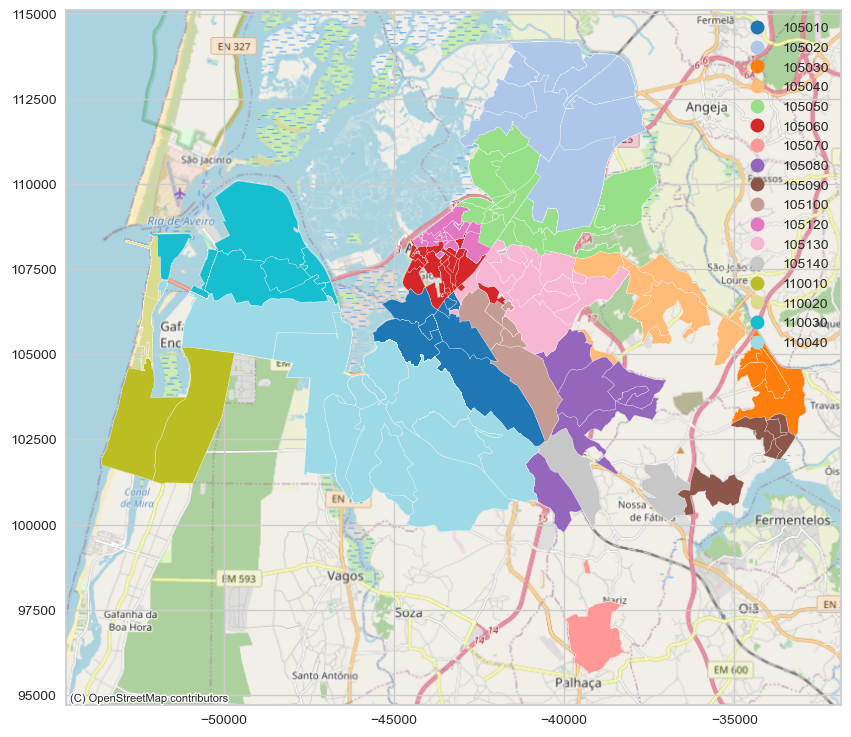

In [220]:
# view Zona_Maxp clusters
ax=all_data.plot(figsize=(10, 10), column="FREGUESIA", categorical=True, edgecolor="w", legend=True, linewidth=0.2,cmap='tab20')
cx.add_basemap(ax,crs=all_data.crs,source=cx.providers.OpenStreetMap.Mapnik)


In [221]:
all_data.reset_index(drop=True, inplace=True)

In [222]:
all_data.head()

ID  Nature  Typology  Status     Price   Log_P_A      A  Year  \
0  268352       2         5       1  224500.0  6.463698  350.0  2008   
1  295929       1         4       3  137000.0  6.851002  145.0  2008   
2  259211       1         3       1  193000.0  6.966439  182.0  2008   
3  259235       2         5       4  374000.0  6.840547  400.0  2008   
4  259235       2         5       4  374000.0  6.840547  400.0  2008   

   Cluster_new  NrUtentes  AL_pc  T  \
0            9        0.0    0.0  0   
1           45        0.0    0.0  0   
2           19        0.0    0.0  0   
3           48        0.0    0.0  0   
4           48        0.0    0.0  0   

                                            geometry      area  Zona_Ward  \
0  POLYGON ((-38979.844 107301.719, -39032.071 10...  0.127582        4.0   
1  POLYGON ((-42807.987 107844.848, -42845.316 10...  0.048703        9.0   
2  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   
3  POLYGON ((-49390.576 107791.820, -49409.232 10...  2.742660        1.0   
4  POLYGON ((-49390.576 107791.820, -49409.232 10...  2.742660        1.0   

   Zona_Ward_Queen  Zona_Maxp  Zona_SKATER   LUGAR FREGUESIA  
0              4.0        5.0          3.0  014742    105040  
1              2.0        2.0          4.0  014757    105120  
2              3.0        4.0          5.0  014757    105120  
3              1.0        1.0          1.0  014935    110030  
4              1.0        1.0          1.0  014930    110040

In [223]:
# check no. of dwellings per cluster in Aveiro Center
pd.pivot_table(all_data, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))
# não incluir cluster 80, 102 e 106, por escassez de dados

Log_P_A
Cluster_new         
1                 99
2                 73
3                 55
4                109
5                123
...              ...
127                2
128                3
129                8
130                3
131               24

[115 rows x 1 columns]

In [224]:
all_data

ID  Nature  Typology  Status     Price   Log_P_A      A  Year  \
0      268352       2         5       1  224500.0  6.463698  350.0  2008   
1      295929       1         4       3  137000.0  6.851002  145.0  2008   
2      259211       1         3       1  193000.0  6.966439  182.0  2008   
3      259235       2         5       4  374000.0  6.840547  400.0  2008   
4      259235       2         5       4  374000.0  6.840547  400.0  2008   
...       ...     ...       ...     ...       ...       ...    ...   ...   
8932  2004573       1         3       3  144500.0  7.337740   94.0  2023   
8933  2004581       2         1       4  390000.0  8.625407   70.0  2023   
8934  2004781       2         4       3  310000.0  8.166991   88.0  2023   
8935  2005854       2         3       4  137500.0  7.704245   62.0  2023   
8936  1897231       1         3       3  135000.0  7.130899  108.0  2022   

      Cluster_new  NrUtentes     AL_pc  T  \
0               9        0.0  0.000000  0   
1              45        0.0  0.000000  0   
2              19        0.0  0.000000  0   
3              48        0.0  0.000000  0   
4              48        0.0  0.000000  0   
...           ...        ...       ... ..   
8932           50       26.0  0.005067  1   
8933           52       15.0  0.004962  1   
8934           81       54.0  0.016744  1   
8935           53       28.0  0.008903  1   
8936           77        0.0  0.000000  1   

                                               geometry      area  Zona_Ward  \
0     POLYGON ((-38979.844 107301.719, -39032.071 10...  0.127582        4.0   
1     POLYGON ((-42807.987 107844.848, -42845.316 10...  0.048703        9.0   
2     POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   
3     POLYGON ((-49390.576 107791.820, -49409.232 10...  2.742660        1.0   
4     POLYGON ((-49390.576 107791.820, -49409.232 10...  2.742660        1.0   
...                                                 ...       ...        ...   
8932  MULTIPOLYGON (((-49710.313 106666.070, -49732....  0.014117        1.0   
8933  POLYGON ((-44460.246 102886.039, -44449.745 10...  0.081206        1.0   
8934  MULTIPOLYGON (((-50725.107 105179.133, -50804....  0.069387        7.0   
8935  MULTIPOLYGON (((-45472.499 103688.848, -45469....  0.002631        1.0   
8936  POLYGON ((-46191.510 102153.896, -46191.615 10...  0.032826        7.0   

      Zona_Ward_Queen  Zona_Maxp  Zona_SKATER   LUGAR FREGUESIA  
0                 4.0        5.0          3.0  014742    105040  
1                 2.0        2.0          4.0  014757    105120  
2                 3.0        4.0          5.0  014757    105120  
3                 1.0        1.0          1.0  014935    110030  
4                 1.0        1.0          1.0  014930    110040  
...               ...        ...          ...     ...       ...  
8932              1.0        1.0          1.0  014935    110030  
8933              1.0        1.0          1.0  014932    110040  
8934              1.0        1.0          1.0  014929    110040  
8935              1.0        1.0          1.0  014932    110040  
8936              1.0        1.0          1.0  014932    110040  

[8937 rows x 20 columns]

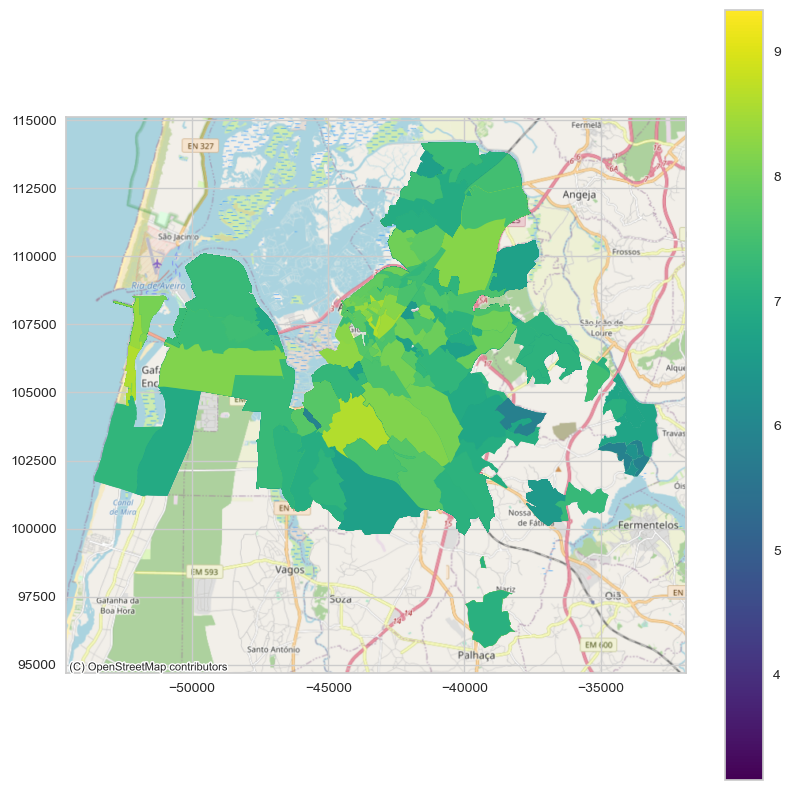

In [225]:
# check log_P_A distribution in the territory
ax=all_data.plot(column=all_data['Log_P_A'], legend=True, figsize=(10,10), cmap='viridis')
cx.add_basemap(ax,crs=all_data.crs,source=cx.providers.OpenStreetMap.Mapnik)

### 6.2 Cluster_new - Linear Regressions (Total Area - Aveiro & Ílhavo)

In [226]:
# get dummies
linreg_center = pd.get_dummies(all_data, columns=['Nature','Typology','Status','Year','Cluster_new'], drop_first=True, dtype=float)

In [227]:
list(linreg_center.columns)

['ID',
 'Price',
 'Log_P_A',
 'A',
 'NrUtentes',
 'AL_pc',
 'T',
 'geometry',
 'area',
 'Zona_Ward',
 'Zona_Ward_Queen',
 'Zona_Maxp',
 'Zona_SKATER',
 'LUGAR',
 'FREGUESIA',
 'Nature_2',
 'Typology_2',
 'Typology_3',
 'Typology_4',
 'Typology_5',
 'Typology_6',
 'Typology_7',
 'Status_2',
 'Status_3',
 'Status_4',
 'Status_5',
 'Year_2006',
 'Year_2007',
 'Year_2008',
 'Year_2009',
 'Year_2010',
 'Year_2018',
 'Year_2019',
 'Year_2020',
 'Year_2021',
 'Year_2022',
 'Year_2023',
 'Cluster_new_2',
 'Cluster_new_3',
 'Cluster_new_4',
 'Cluster_new_5',
 'Cluster_new_6',
 'Cluster_new_7',
 'Cluster_new_8',
 'Cluster_new_9',
 'Cluster_new_10',
 'Cluster_new_11',
 'Cluster_new_12',
 'Cluster_new_13',
 'Cluster_new_14',
 'Cluster_new_15',
 'Cluster_new_16',
 'Cluster_new_17',
 'Cluster_new_18',
 'Cluster_new_19',
 'Cluster_new_20',
 'Cluster_new_21',
 'Cluster_new_22',
 'Cluster_new_24',
 'Cluster_new_26',
 'Cluster_new_27',
 'Cluster_new_28',
 'Cluster_new_30',
 'Cluster_new_31',
 'Cluster_n

In [228]:
# define X and y
c_y_eur_area  = linreg_center['Log_P_A'].astype(float)

c_X_eur_area = linreg_center[['Typology_2','Typology_3', 'Typology_4', 'Typology_5', 'Typology_6', 
                              'Typology_7', 'Nature_2', 'Status_2', 'Status_3',
                              'Status_4', 'Status_5', 'Year_2006', 'Year_2007',
                              'Year_2008','Year_2009', 'Year_2010', 'Year_2018',
                              'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022',
                              'Year_2023', 'Cluster_new_2', 'Cluster_new_3', 'Cluster_new_4',
                              'Cluster_new_5', 'Cluster_new_6', 'Cluster_new_7', 'Cluster_new_8',
                              'Cluster_new_9', 'Cluster_new_10', 'Cluster_new_11', 'Cluster_new_12',
                              'Cluster_new_13', 'Cluster_new_14', 'Cluster_new_15', 'Cluster_new_16', 
                              'Cluster_new_17', 'Cluster_new_18', 'Cluster_new_19', 'Cluster_new_20',
                              'Cluster_new_21', 'Cluster_new_22', 'Cluster_new_24', 'Cluster_new_26', 
                              'Cluster_new_27', 'Cluster_new_28', 'Cluster_new_30', 'Cluster_new_31',
                              'Cluster_new_32', 'Cluster_new_33', 'Cluster_new_34', 'Cluster_new_35', 
                              'Cluster_new_36', 'Cluster_new_37', 'Cluster_new_38', 'Cluster_new_39',
                              'Cluster_new_40', 'Cluster_new_41', 'Cluster_new_42', 'Cluster_new_43', 
                              'Cluster_new_45', 'Cluster_new_47', 'Cluster_new_48', 'Cluster_new_49', 
                              'Cluster_new_50', 'Cluster_new_51', 'Cluster_new_52', 'Cluster_new_53', 
                              'Cluster_new_54', 'Cluster_new_55', 'Cluster_new_56', 'Cluster_new_57', 
                              'Cluster_new_58', 'Cluster_new_59', 'Cluster_new_60', 'Cluster_new_61', 
                              'Cluster_new_62', 'Cluster_new_63', 'Cluster_new_64', 'Cluster_new_65', 
                              'Cluster_new_66', 'Cluster_new_67', 'Cluster_new_69', 'Cluster_new_70', 
                              'Cluster_new_71', 'Cluster_new_74', 'Cluster_new_75', 'Cluster_new_76', 
                              'Cluster_new_77', 'Cluster_new_78', 'Cluster_new_79', 'Cluster_new_80', 
                              'Cluster_new_81', 'Cluster_new_82', 'Cluster_new_83', 'Cluster_new_84', 
                              'Cluster_new_85', 'Cluster_new_86', 'Cluster_new_88', 'Cluster_new_89', 
                              'Cluster_new_90', 'Cluster_new_91', 'Cluster_new_96', 'Cluster_new_97', 
                              'Cluster_new_98', 'Cluster_new_99', 'Cluster_new_100', 'Cluster_new_101', 
                              'Cluster_new_102', 'Cluster_new_103', 'Cluster_new_104', 'Cluster_new_105', 
                              'Cluster_new_106', 'Cluster_new_107', 'Cluster_new_108', 'Cluster_new_109', 
                              'Cluster_new_111', 'Cluster_new_112', 'Cluster_new_114', 'Cluster_new_115', 
                              'Cluster_new_116', 'Cluster_new_117', 'Cluster_new_118', 'Cluster_new_119', 
                              'Cluster_new_120', 'Cluster_new_122', 'Cluster_new_123', 'Cluster_new_124', 
                              'Cluster_new_125', 'Cluster_new_126', 'Cluster_new_127', 'Cluster_new_128', 
                              'Cluster_new_129', 'Cluster_new_130', 'Cluster_new_131']].astype(float)


# menos de 10 casos - Clusters: 106.0, 102.0, 80.0, 28.0 e 22.0, 110.0
# removido Log_IPI, Year_2023, Year_2018 VIF muito alto

In [229]:
# check VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = c_X_eur_area.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(c_X_eur_area.values, i)
                          for i in range(len(c_X_eur_area.columns))]

print(vif_data)

             feature        VIF
0         Typology_2   8.057035
1         Typology_3  20.693669
2         Typology_4  16.090411
3         Typology_5  11.287803
4         Typology_6   2.202289
..               ...        ...
131  Cluster_new_127   1.017818
132  Cluster_new_128   1.025390
133  Cluster_new_129   1.072878
134  Cluster_new_130   1.053608
135  Cluster_new_131   1.197453

[136 rows x 2 columns]


In [230]:
# linear model for casasapo with log of price per square meter as dependent variable
c_X_eur_area = sm.add_constant(c_X_eur_area)
model_c_eur_area = sm.OLS(c_y_eur_area, c_X_eur_area)
results_c_eur_area = model_c_eur_area.fit()
results_c_eur_area.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.568    
Dependent Variable: Log_P_A          AIC:                1272.9582
Date:               2023-06-02 10:43 BIC:                2245.3781
No. Observations:   8937             Log-Likelihood:     -499.48  
Df Model:           136              F-statistic:        87.22    
Df Residuals:       8800             Prob (F-statistic): 0.00     
R-squared:          0.574            Scale:              0.066494 
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
const              7.3088   0.0578 126.4260 0.0000  7.1955  7.4221
Typology_2        -0.1405   0.0225  -6.2355 0.0000 -0.1847 -0.0963
Typology_3        -0.2263   0.0220 -10.3043 0.0000 -0.2693 -0.1832
Typology_4        -0.2835   0.0223 -12.7400 0.0000 -0.3271 -0.2399
Typology_5        -0.3018   0.0235 -12.8158 0.0000 -0.3479 -0.2556
Typology_6        -0.3348   0.0307 -10.9124 0.0000 -0.3949 -0.2746
Typology_7        -0.4021   0.0491  -8.1961 0.0000 -0.4982 -0.3059
Nature_2          -0.1343   0.0108 -12.4616 0.0000 -0.1554 -0.1132
Status_2          -0.0614   0.0085  -7.1875 0.0000 -0.0781 -0.0446
Status_3          -0.2054   0.0085 -24.1253 0.0000 -0.2221 -0.1887
Status_4          -0.3447   0.0134 -25.6438 0.0000 -0.3710 -0.3183
Status_5           0.0475   0.0085   5.5815 0.0000  0.0308  0.0642
Year_2006          0.0657   0.0515   1.2765 0.2018 -0.0352  0.1667
Year_2007          0.0401   0.0496   0.8094 0.4183 -0.0571  0.1373
Year_2008          0.0253   0.0493   0.5119 0.6088 -0.0715  0.1220
Year_2009          0.0048   0.0494   0.0976 0.9222 -0.0921  0.1018
Year_2010          0.0249   0.0493   0.5043 0.6141 -0.0718  0.1215
Year_2018          0.3538   0.0505   7.0069 0.0000  0.2548  0.4528
Year_2019          0.4539   0.0607   7.4750 0.0000  0.3349  0.5729
Year_2020          0.5139   0.0517   9.9415 0.0000  0.4126  0.6152
Year_2021          0.5861   0.0516  11.3560 0.0000  0.4850  0.6873
Year_2022          0.7901   0.0526  15.0330 0.0000  0.6870  0.8931
Year_2023          1.0533   0.0867  12.1429 0.0000  0.8833  1.2234
Cluster_new_2     -0.1138   0.0313  -3.6350 0.0003 -0.1752 -0.0524
Cluster_new_3      0.0255   0.0373   0.6841 0.4939 -0.0476  0.0987
Cluster_new_4     -0.1191   0.0297  -4.0051 0.0001 -0.1774 -0.0608
Cluster_new_5     -0.0746   0.0285  -2.6174 0.0089 -0.1305 -0.0187
Cluster_new_6     -0.1921   0.0289  -6.6420 0.0000 -0.2488 -0.1354
Cluster_new_7     -0.0754   0.0328  -2.3027 0.0213 -0.1396 -0.0112
Cluster_new_8     -0.1790   0.0372  -4.8086 0.0000 -0.2520 -0.1060
Cluster_new_9     -0.1761   0.0244  -7.2100 0.0000 -0.2239 -0.1282
Cluster_new_10    -0.3589   0.1308  -2.7429 0.0061 -0.6154 -0.1024
Cluster_new_11     0.0113   0.0338   0.3332 0.7390 -0.0550  0.0775
Cluster_new_12     0.0406   0.0302   1.3411 0.1799 -0.0187  0.0998
Cluster_new_13    -0.1612   0.0354  -4.5584 0.0000 -0.2305 -0.0919
Cluster_new_14    -0.0866   0.0375  -2.3113 0.0208 -0.1600 -0.0132
Cluster_new_15    -0.0010   0.0328  -0.0309 0.9754 -0.0652  0.0632
Cluster_new_16    -0.0446   0.0235  -1.8985 0.0577 -0.0907  0.0015
Cluster_new_17    -0.2657   0.0437  -6.0764 0.0000 -0.3514 -0.1800
Cluster_new_18    -0.0131   0.0278  -0.4711 0.6376 -0.0675  0.0413
Cluster_new_19     0.1260   0.0230   5.4741 0.0000  0.0809  0.1712
Cluster_new_20    -0.0191   0.0320  -0.5965 0.5509 -0.0819  0.0437
Cluster_new_21     0.0099   0.0274   0.3590 0.7196 -0.0439  0.0636
Cluster_new_22     0.1662   0.1176   1.4128 0.1578 -0.0644  0.3967
Cluster_new_24     0.1358   0.0311   4.3717 0.0000  0.0749  0.1967
Cluster_new_26     0.1853   0.0353   5.2541 0.0000  0.1162  0.2545
Cluster_new_27     0.1053   0.0369   2.8563 0.0043  0.0330  0.1776
Cluster_new_28  

In [231]:
results_c_eur_area.mse_model

5.799399348577167

In [232]:
math.sqrt(results_c_eur_area.mse_model)

2.408194209065616

### 6.3 Freguesia - Linear Regressions (Total Area - Aveiro & Ílhavo)

In [233]:
# get dummies
linreg_center = pd.get_dummies(all_data, columns=['Nature','Typology','Status','Year','FREGUESIA'], drop_first=True, dtype=float)

In [234]:
list(linreg_center.columns)

['ID',
 'Price',
 'Log_P_A',
 'A',
 'Cluster_new',
 'NrUtentes',
 'AL_pc',
 'T',
 'geometry',
 'area',
 'Zona_Ward',
 'Zona_Ward_Queen',
 'Zona_Maxp',
 'Zona_SKATER',
 'LUGAR',
 'Nature_2',
 'Typology_2',
 'Typology_3',
 'Typology_4',
 'Typology_5',
 'Typology_6',
 'Typology_7',
 'Status_2',
 'Status_3',
 'Status_4',
 'Status_5',
 'Year_2006',
 'Year_2007',
 'Year_2008',
 'Year_2009',
 'Year_2010',
 'Year_2018',
 'Year_2019',
 'Year_2020',
 'Year_2021',
 'Year_2022',
 'Year_2023',
 'FREGUESIA_105020',
 'FREGUESIA_105030',
 'FREGUESIA_105040',
 'FREGUESIA_105050',
 'FREGUESIA_105060',
 'FREGUESIA_105070',
 'FREGUESIA_105080',
 'FREGUESIA_105090',
 'FREGUESIA_105100',
 'FREGUESIA_105120',
 'FREGUESIA_105130',
 'FREGUESIA_105140',
 'FREGUESIA_110010',
 'FREGUESIA_110020',
 'FREGUESIA_110030',
 'FREGUESIA_110040']

In [235]:
# define X and y
c_y_eur_area  = linreg_center['Log_P_A'].astype(float)

c_X_eur_area = linreg_center[['Typology_2','Typology_3', 'Typology_4', 'Typology_5', 'Typology_6', 
                              'Typology_7', 'Nature_2', 'Status_2', 'Status_3',
                              'Status_4', 'Status_5', 'Year_2006', 'Year_2007',
                              'Year_2008','Year_2009', 'Year_2010', 'Year_2018',
                              'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022',
                              'Year_2023', 'FREGUESIA_105020','FREGUESIA_105030', 'FREGUESIA_105040',
                              'FREGUESIA_105050', 'FREGUESIA_105060', 'FREGUESIA_105070', 'FREGUESIA_105080',
                              'FREGUESIA_105090', 'FREGUESIA_105100', 'FREGUESIA_105120', 'FREGUESIA_105130',
                              'FREGUESIA_105140', 'FREGUESIA_110010', 'FREGUESIA_110020', 'FREGUESIA_110030',
                              'FREGUESIA_110040']].astype(float)


# menos de 10 casos - Clusters: 106.0, 102.0, 80.0, 28.0 e 22.0, 110.0
# removido Log_IPI, Year_2023, Year_2018 VIF muito alto

In [236]:
# check VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = c_X_eur_area.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(c_X_eur_area.values, i)
                          for i in range(len(c_X_eur_area.columns))]

print(vif_data)

             feature        VIF
0         Typology_2   7.578146
1         Typology_3  19.261883
2         Typology_4  14.909411
3         Typology_5  10.471194
4         Typology_6   2.074400
5         Typology_7   1.286321
6           Nature_2   2.862018
7           Status_2   1.958722
8           Status_3   2.106575
9           Status_4   1.591345
10          Status_5   2.004065
11         Year_2006   2.660764
12         Year_2007   9.519934
13         Year_2008  13.046711
14         Year_2009  10.500069
15         Year_2010  15.357503
16         Year_2018   6.421734
17         Year_2019   1.497640
18         Year_2020   3.378407
19         Year_2021   3.232335
20         Year_2022   2.619315
21         Year_2023   1.094329
22  FREGUESIA_105020   1.836168
23  FREGUESIA_105030   1.021910
24  FREGUESIA_105040   1.628863
25  FREGUESIA_105050   2.687545
26  FREGUESIA_105060   2.046856
27  FREGUESIA_105070   1.026436
28  FREGUESIA_105080   1.204018
29  FREGUESIA_105090   1.013330
30  FREG

In [237]:
# linear model for casasapo with log of price per square meter as dependent variable
c_X_eur_area = sm.add_constant(c_X_eur_area)
model_c_eur_area = sm.OLS(c_y_eur_area, c_X_eur_area)
results_c_eur_area = model_c_eur_area.fit()
results_c_eur_area.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.510    
Dependent Variable: Log_P_A          AIC:                2285.5167
Date:               2023-06-02 10:43 BIC:                2562.3370
No. Observations:   8937             Log-Likelihood:     -1103.8  
Df Model:           38               F-statistic:        246.1    
Df Residuals:       8898             Prob (F-statistic): 0.00     
R-squared:          0.512            Scale:              0.075283 
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
const              7.2757   0.0573 126.9902 0.0000  7.1634  7.3881
Typology_2        -0.1287   0.0234  -5.5081 0.0000 -0.1745 -0.0829
Typology_3        -0.2157   0.0226  -9.5329 0.0000 -0.2601 -0.1713
Typology_4        -0.2730   0.0228 -11.9496 0.0000 -0.3178 -0.2282
Typology_5        -0.2845   0.0242 -11.7435 0.0000 -0.3320 -0.2370
Typology_6        -0.3004   0.0318  -9.4575 0.0000 -0.3626 -0.2381
Typology_7        -0.4023   0.0512  -7.8587 0.0000 -0.5026 -0.3019
Nature_2          -0.1827   0.0104 -17.5989 0.0000 -0.2030 -0.1623
Status_2          -0.0768   0.0088  -8.7358 0.0000 -0.0940 -0.0595
Status_3          -0.2263   0.0087 -25.9316 0.0000 -0.2434 -0.2092
Status_4          -0.3664   0.0137 -26.8320 0.0000 -0.3931 -0.3396
Status_5           0.0625   0.0087   7.1693 0.0000  0.0454  0.0797
Year_2006          0.0949   0.0547   1.7364 0.0825 -0.0122  0.2020
Year_2007          0.0636   0.0525   1.2097 0.2264 -0.0394  0.1665
Year_2008          0.0460   0.0523   0.8797 0.3791 -0.0565  0.1486
Year_2009          0.0354   0.0524   0.6752 0.4996 -0.0674  0.1382
Year_2010          0.0550   0.0522   1.0523 0.2927 -0.0474  0.1574
Year_2018          0.3524   0.0530   6.6441 0.0000  0.2485  0.4564
Year_2019          0.5878   0.0616   9.5383 0.0000  0.4670  0.7087
Year_2020          0.4931   0.0542   9.1003 0.0000  0.3869  0.5993
Year_2021          0.6287   0.0543  11.5881 0.0000  0.5223  0.7350
Year_2022          0.8234   0.0550  14.9809 0.0000  0.7157  0.9312
Year_2023          1.1264   0.0880  12.7975 0.0000  0.9539  1.2990
FREGUESIA_105020  -0.0691   0.0155  -4.4487 0.0000 -0.0996 -0.0387
FREGUESIA_105030  -0.3474   0.0837  -4.1522 0.0000 -0.5114 -0.1834
FREGUESIA_105040  -0.1611   0.0163  -9.8637 0.0000 -0.1931 -0.1291
FREGUESIA_105050  -0.0458   0.0126  -3.6451 0.0003 -0.0704 -0.0212
FREGUESIA_105060   0.0928   0.0147   6.3153 0.0000  0.0640  0.1216
FREGUESIA_105070  -0.2195   0.1051  -2.0891 0.0367 -0.4255 -0.0135
FREGUESIA_105080  -0.2648   0.0268  -9.8936 0.0000 -0.3172 -0.2123
FREGUESIA_105090  -0.5618   0.1235  -4.5482 0.0000 -0.8040 -0.3197
FREGUESIA_105100  -0.0141   0.0138  -1.0238 0.3060 -0.0411  0.0129
FREGUESIA_105120   0.1761   0.0120  14.7194 0.0000  0.1527  0.1996
FREGUESIA_105130  -0.0011   0.0210  -0.0518 0.9587 -0.0422  0.0400
FREGUESIA_105140  -0.1488   0.0280  -5.3070 0.0000 -0.2037 -0.0938
FREGUESIA_110010  -0.1608   0.1130  -1.4229 0.1548 -0.3823  0.0607
FREGUESIA_110020   0.3912   0.0169  23.1382 0.0000  0.3581  0.4244
FREGUESIA_110030   0.1281   0.0145   8.8532 0.0000  0.0997  0.1564
FREGUESIA_110040  -0.0836   0.0145  -5.7678 0.0000 -0.1120 -0.0552
------------------------------------------------------------------
Omnibus:            2564.255      Durbin-Watson:         1.743    
Prob(Omnibus):      0.000         Jarque-Bera (JB):      71817.162
Skew:               -0.777        Prob(JB):              0.000    
Kurtosis:           16.800        Condition No.:         83       
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

In [238]:
results_c_eur_area.mse_model

18.52602622500271

In [239]:
math.sqrt(results_c_eur_area.mse_model)

4.304187057389898

### 6.4 Lugar - Linear Regressions (Total Area - Aveiro & Ílhavo)

In [240]:
# get dummies
linreg_center = pd.get_dummies(all_data, columns=['Nature','Typology','Status','Year','LUGAR'], drop_first=True, dtype=float)

In [241]:
list(linreg_center.columns)

['ID',
 'Price',
 'Log_P_A',
 'A',
 'Cluster_new',
 'NrUtentes',
 'AL_pc',
 'T',
 'geometry',
 'area',
 'Zona_Ward',
 'Zona_Ward_Queen',
 'Zona_Maxp',
 'Zona_SKATER',
 'FREGUESIA',
 'Nature_2',
 'Typology_2',
 'Typology_3',
 'Typology_4',
 'Typology_5',
 'Typology_6',
 'Typology_7',
 'Status_2',
 'Status_3',
 'Status_4',
 'Status_5',
 'Year_2006',
 'Year_2007',
 'Year_2008',
 'Year_2009',
 'Year_2010',
 'Year_2018',
 'Year_2019',
 'Year_2020',
 'Year_2021',
 'Year_2022',
 'Year_2023',
 'LUGAR_014733',
 'LUGAR_014734',
 'LUGAR_014735',
 'LUGAR_014736',
 'LUGAR_014737',
 'LUGAR_014738',
 'LUGAR_014739',
 'LUGAR_014740',
 'LUGAR_014741',
 'LUGAR_014742',
 'LUGAR_014743',
 'LUGAR_014744',
 'LUGAR_014745',
 'LUGAR_014750',
 'LUGAR_014751',
 'LUGAR_014752',
 'LUGAR_014753',
 'LUGAR_014754',
 'LUGAR_014755',
 'LUGAR_014757',
 'LUGAR_014759',
 'LUGAR_014760',
 'LUGAR_014761',
 'LUGAR_014762',
 'LUGAR_014763',
 'LUGAR_014764',
 'LUGAR_014765',
 'LUGAR_014767',
 'LUGAR_014768',
 'LUGAR_014773',


In [242]:
# define X and y
c_y_eur_area  = linreg_center['Log_P_A'].astype(float)

c_X_eur_area = linreg_center[['Typology_2','Typology_3', 'Typology_4', 'Typology_5', 'Typology_6', 
                              'Typology_7', 'Nature_2', 'Status_2', 'Status_3',
                              'Status_4', 'Status_5', 'Year_2006', 'Year_2007',
                              'Year_2008','Year_2009', 'Year_2010', 'Year_2018',
                              'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022',
                              'Year_2023', 'LUGAR_014733', 'LUGAR_014734', 'LUGAR_014735', 'LUGAR_014736',
                              'LUGAR_014737', 'LUGAR_014738', 'LUGAR_014739', 'LUGAR_014740', 'LUGAR_014741',
                              'LUGAR_014742', 'LUGAR_014743', 'LUGAR_014744', 'LUGAR_014745', 'LUGAR_014750',
                              'LUGAR_014751', 'LUGAR_014752', 'LUGAR_014753', 'LUGAR_014754', 'LUGAR_014755',
                              'LUGAR_014757', 'LUGAR_014759', 'LUGAR_014760', 'LUGAR_014761', 'LUGAR_014762',
                              'LUGAR_014763', 'LUGAR_014764', 'LUGAR_014765', 'LUGAR_014767', 'LUGAR_014768',
                              'LUGAR_014773', 'LUGAR_014926', 'LUGAR_014927', 'LUGAR_014929', 'LUGAR_014930',
                              'LUGAR_014932', 'LUGAR_014933', 'LUGAR_014935']].astype(float)


# menos de 10 casos - Clusters: 106.0, 102.0, 80.0, 28.0 e 22.0, 110.0
# removido Log_IPI, Year_2023, Year_2018 VIF muito alto

In [243]:
# check VIF
vif_data = pd.DataFrame()
vif_data["feature"] = c_X_eur_area.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(c_X_eur_area.values, i)
                          for i in range(len(c_X_eur_area.columns))]

print(vif_data)

         feature        VIF
0     Typology_2   7.631171
1     Typology_3  19.328180
2     Typology_4  15.003433
3     Typology_5  10.605025
4     Typology_6   2.099647
5     Typology_7   1.300569
6       Nature_2   3.026364
7       Status_2   1.990810
8       Status_3   2.099198
9       Status_4   1.596909
10      Status_5   2.008672
11     Year_2006   3.568397
12     Year_2007  14.027335
13     Year_2008  19.435782
14     Year_2009  15.662616
15     Year_2010  23.532554
16     Year_2018   8.930738
17     Year_2019   1.762593
18     Year_2020   4.649517
19     Year_2021   4.393984
20     Year_2022   3.482797
21     Year_2023   1.147374
22  LUGAR_014733   2.006298
23  LUGAR_014734   1.101527
24  LUGAR_014735   1.161248
25  LUGAR_014736   2.414304
26  LUGAR_014737   1.868969
27  LUGAR_014738   2.008631
28  LUGAR_014739   1.019528
29  LUGAR_014740   1.007645
30  LUGAR_014741   1.066734
31  LUGAR_014742   3.589954
32  LUGAR_014743   1.219770
33  LUGAR_014744   1.023235
34  LUGAR_014745   1

In [244]:
# linear model for casasapo with log of price per square meter as dependent variable
c_X_eur_area = sm.add_constant(c_X_eur_area)
model_c_eur_area = sm.OLS(c_y_eur_area, c_X_eur_area)
results_c_eur_area = model_c_eur_area.fit()
results_c_eur_area.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.491    
Dependent Variable: Log_P_A          AIC:                2648.6812
Date:               2023-06-02 10:43 BIC:                3074.5586
No. Observations:   8937             Log-Likelihood:     -1264.3  
Df Model:           59               F-statistic:        147.2    
Df Residuals:       8877             Prob (F-statistic): 0.00     
R-squared:          0.495            Scale:              0.078223 
-------------------------------------------------------------------
               Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const          7.2001    0.0613  117.4373  0.0000   7.0800   7.3203
Typology_2    -0.1440    0.0237   -6.0703  0.0000  -0.1904  -0.0975
Typology_3    -0.2407    0.0229  -10.5157  0.0000  -0.2855  -0.1958
Typology_4    -0.2916    0.0231  -12.6100  0.0000  -0.3369  -0.2463
Typology_5    -0.3002    0.0246  -12.1959  0.0000  -0.3485  -0.2520
Typology_6    -0.3148    0.0323   -9.7329  0.0000  -0.3782  -0.2514
Typology_7    -0.4010    0.0523   -7.6638  0.0000  -0.5036  -0.2984
Nature_2      -0.2040    0.0109  -18.7465  0.0000  -0.2253  -0.1827
Status_2      -0.0804    0.0090   -8.8831  0.0000  -0.0981  -0.0626
Status_3      -0.2260    0.0089  -25.4279  0.0000  -0.2434  -0.2086
Status_4      -0.3787    0.0139  -27.1602  0.0000  -0.4061  -0.3514
Status_5       0.0576    0.0089    6.4707  0.0000   0.0402   0.0750
Year_2006      0.1074    0.0557    1.9269  0.0540  -0.0019   0.2167
Year_2007      0.0752    0.0536    1.4032  0.1606  -0.0298   0.1803
Year_2008      0.0667    0.0534    1.2504  0.2112  -0.0379   0.1713
Year_2009      0.0529    0.0535    0.9889  0.3227  -0.0519   0.1577
Year_2010      0.0604    0.0533    1.1324  0.2575  -0.0441   0.1649
Year_2018      0.3613    0.0541    6.6773  0.0000   0.2552   0.4673
Year_2019      0.5787    0.0630    9.1854  0.0000   0.4552   0.7022
Year_2020      0.4968    0.0554    8.9756  0.0000   0.3883   0.6053
Year_2021      0.6404    0.0554   11.5559  0.0000   0.5318   0.7490
Year_2022      0.8350    0.0561   14.8806  0.0000   0.7250   0.9450
Year_2023      1.1777    0.0897   13.1236  0.0000   1.0018   1.3536
LUGAR_014733   0.1112    0.0316    3.5212  0.0004   0.0493   0.1731
LUGAR_014734  -0.0648    0.0762   -0.8506  0.3950  -0.2141   0.0845
LUGAR_014735  -0.1150    0.0633   -1.8174  0.0692  -0.2391   0.0090
LUGAR_014736   0.0988    0.0297    3.3287  0.0009   0.0406   0.1570
LUGAR_014737   0.0680    0.0333    2.0392  0.0415   0.0026   0.1333
LUGAR_014738  -0.0727    0.0315   -2.3054  0.0212  -0.1346  -0.0109
LUGAR_014739  -0.2565    0.1632   -1.5718  0.1160  -0.5765   0.0634
LUGAR_014740   0.0031    0.2809    0.0111  0.9912  -0.5474   0.5537
LUGAR_014741  -0.2801    0.0917   -3.0531  0.0023  -0.4599  -0.1003
LUGAR_014742  -0.0725    0.0268   -2.7089  0.0068  -0.1250  -0.0200
LUGAR_014743  -0.0803    0.0551   -1.4563  0.1453  -0.1884   0.0278
LUGAR_014744   0.1005    0.1635    0.6149  0.5387  -0.2200   0.4210
LUGAR_014745  -0.1276    0.1091   -1.1695  0.2422  -0.3414   0.0862
LUGAR_014750  -0.1319    0.0457   -2.8863  0.0039  -0.2214  -0.0423
LUGAR_014751  -0.1871    0.0412   -4.5392  0.0000  -0.2679  -0.1063
LUGAR_014752  -0.1874    0.1996   -0.9393  0.3476  -0.5786   0.2037
LUGAR_014753  -0.0741    0.0668   -1.1090  0.2675  -0.2051   0.0569
LUGAR_014754  -0.0534    0.0374   -1.4263  0.1538  -0.1267   0.0200
LUGAR_014755  -0.6319    0.1634   -3.8665  0.0001  -0.9522  -0.3115
LUGAR_014757   0.1696    0.0235    7.2101  0.0000   0.1235   0.2158
LUGAR_014759   0.0915    0.0459    1.9952  0.0461   0.0016   0.1814
LUGAR_014760   0.0357    0.0257    1.3884  0.1651  -0.0147   0.0860
LUGAR_014761   0.1079    0.0298    3.6255  0.0003   0.0495   0.1662
LUGAR_014762   0.1502    0.1170   

In [245]:
results_c_eur_area.mse_model

11.516582341128174

In [246]:
math.sqrt(results_c_eur_area.mse_model)

3.3936090436478055

### 6.5 MaxP - Linear Regressions (Total Area - Aveiro & Ílhavo)

In [247]:
# get dummies
linreg_center = pd.get_dummies(all_data, columns=['Nature','Typology','Status','Year','Zona_Maxp'], drop_first=True, dtype=float)

In [248]:
list(linreg_center.columns)

['ID',
 'Price',
 'Log_P_A',
 'A',
 'Cluster_new',
 'NrUtentes',
 'AL_pc',
 'T',
 'geometry',
 'area',
 'Zona_Ward',
 'Zona_Ward_Queen',
 'Zona_SKATER',
 'LUGAR',
 'FREGUESIA',
 'Nature_2',
 'Typology_2',
 'Typology_3',
 'Typology_4',
 'Typology_5',
 'Typology_6',
 'Typology_7',
 'Status_2',
 'Status_3',
 'Status_4',
 'Status_5',
 'Year_2006',
 'Year_2007',
 'Year_2008',
 'Year_2009',
 'Year_2010',
 'Year_2018',
 'Year_2019',
 'Year_2020',
 'Year_2021',
 'Year_2022',
 'Year_2023',
 'Zona_Maxp_2.0',
 'Zona_Maxp_3.0',
 'Zona_Maxp_4.0',
 'Zona_Maxp_5.0',
 'Zona_Maxp_6.0',
 'Zona_Maxp_7.0']

In [249]:
# define X and y
c_y_eur_area  = linreg_center['Log_P_A'].astype(float)

c_X_eur_area = linreg_center[['Typology_2','Typology_3', 'Typology_4', 'Typology_5', 'Typology_6', 
                              'Typology_7', 'Nature_2', 'Status_2', 'Status_3',
                              'Status_4', 'Status_5', 'Year_2006', 'Year_2007',
                              'Year_2008','Year_2009', 'Year_2010', 'Year_2018',
                              'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022',
                              'Year_2023', 'Zona_Maxp_2.0', 'Zona_Maxp_3.0', 'Zona_Maxp_4.0',
                              'Zona_Maxp_5.0', 'Zona_Maxp_6.0', 'Zona_Maxp_7.0']].astype(float)


# menos de 10 casos - Clusters: 106.0, 102.0, 80.0, 28.0 e 22.0, 110.0
# removido Log_IPI, Year_2023, Year_2018 VIF muito alto

In [250]:
# check VIF
vif_data = pd.DataFrame()
vif_data["feature"] = c_X_eur_area.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(c_X_eur_area.values, i)
                          for i in range(len(c_X_eur_area.columns))]

print(vif_data)

          feature        VIF
0      Typology_2   7.533618
1      Typology_3  18.977899
2      Typology_4  14.733655
3      Typology_5  10.434476
4      Typology_6   2.068147
5      Typology_7   1.285096
6        Nature_2   2.755963
7        Status_2   1.946068
8        Status_3   2.074638
9        Status_4   1.568363
10       Status_5   1.989454
11      Year_2006   2.533428
12      Year_2007   9.020807
13      Year_2008  12.213309
14      Year_2009   9.791545
15      Year_2010  14.560851
16      Year_2018   5.903386
17      Year_2019   1.461185
18      Year_2020   3.191022
19      Year_2021   3.064713
20      Year_2022   2.456810
21      Year_2023   1.084388
22  Zona_Maxp_2.0   2.223301
23  Zona_Maxp_3.0   1.676532
24  Zona_Maxp_4.0   1.980254
25  Zona_Maxp_5.0   1.650467
26  Zona_Maxp_6.0   1.024329
27  Zona_Maxp_7.0   1.206419


In [251]:
# linear model for casasapo with log of price per square meter as dependent variable
c_X_eur_area = sm.add_constant(c_X_eur_area)
model_c_eur_area = sm.OLS(c_y_eur_area, c_X_eur_area)
results_c_eur_area = model_c_eur_area.fit()
results_c_eur_area.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.449    
Dependent Variable: Log_P_A          AIC:                3326.8681
Date:               2023-06-02 10:44 BIC:                3532.7088
No. Observations:   8937             Log-Likelihood:     -1634.4  
Df Model:           28               F-statistic:        261.3    
Df Residuals:       8908             Prob (F-statistic): 0.00     
R-squared:          0.451            Scale:              0.084681 
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
const              7.3515   0.0602 122.0506 0.0000  7.2335  7.4696
Typology_2        -0.1079   0.0247  -4.3599 0.0000 -0.1564 -0.0594
Typology_3        -0.2028   0.0239  -8.4799 0.0000 -0.2496 -0.1559
Typology_4        -0.2589   0.0241 -10.7239 0.0000 -0.3062 -0.2116
Typology_5        -0.2797   0.0257 -10.9032 0.0000 -0.3300 -0.2294
Typology_6        -0.2728   0.0336  -8.1123 0.0000 -0.3387 -0.2069
Typology_7        -0.3759   0.0543  -6.9269 0.0000 -0.4823 -0.2695
Nature_2          -0.2230   0.0108 -20.6433 0.0000 -0.2442 -0.2018
Status_2          -0.0926   0.0093  -9.9705 0.0000 -0.1108 -0.0744
Status_3          -0.2343   0.0092 -25.4860 0.0000 -0.2523 -0.2162
Status_4          -0.3847   0.0144 -26.7519 0.0000 -0.4129 -0.3565
Status_5           0.0649   0.0092   7.0323 0.0000  0.0468  0.0829
Year_2006          0.1370   0.0579   2.3657 0.0180  0.0235  0.2506
Year_2007          0.0826   0.0557   1.4834 0.1380 -0.0266  0.1918
Year_2008          0.0767   0.0555   1.3822 0.1669 -0.0321  0.1854
Year_2009          0.0735   0.0556   1.3217 0.1863 -0.0355  0.1824
Year_2010          0.0811   0.0554   1.4634 0.1434 -0.0275  0.1897
Year_2018          0.3449   0.0562   6.1386 0.0000  0.2348  0.4550
Year_2019          0.6186   0.0653   9.4754 0.0000  0.4906  0.7466
Year_2020          0.4996   0.0574   8.7019 0.0000  0.3870  0.6121
Year_2021          0.6586   0.0575  11.4500 0.0000  0.5458  0.7713
Year_2022          0.8347   0.0582  14.3428 0.0000  0.7206  0.9488
Year_2023          1.1386   0.0933  12.2041 0.0000  0.9557  1.3215
Zona_Maxp_2.0     -0.0406   0.0092  -4.4038 0.0000 -0.0586 -0.0225
Zona_Maxp_3.0     -0.1528   0.0103 -14.7753 0.0000 -0.1731 -0.1326
Zona_Maxp_4.0      0.0420   0.0098   4.2815 0.0000  0.0227  0.0612
Zona_Maxp_5.0     -0.1912   0.0106 -18.0213 0.0000 -0.2120 -0.1704
Zona_Maxp_6.0     -0.2745   0.0547  -5.0195 0.0000 -0.3817 -0.1673
Zona_Maxp_7.0     -0.2236   0.0180 -12.3899 0.0000 -0.2589 -0.1882
------------------------------------------------------------------
Omnibus:            2117.894      Durbin-Watson:         1.709    
Prob(Omnibus):      0.000         Jarque-Bera (JB):      45360.282
Skew:               -0.609        Prob(JB):              0.000    
Kurtosis:           13.970        Condition No.:         84       
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

In [252]:
results_c_eur_area.mse_model

22.125676498439184

In [253]:
math.sqrt(results_c_eur_area.mse_model)

4.703793840979766

### 6.6 SKATER - Linear Regressions (Total Area - Aveiro & Ílhavo)

In [254]:
# get dummies
linreg_center = pd.get_dummies(all_data, columns=['Nature','Typology','Status','Year','Zona_SKATER'], drop_first=True, dtype=float)

In [255]:
list(linreg_center.columns)

['ID',
 'Price',
 'Log_P_A',
 'A',
 'Cluster_new',
 'NrUtentes',
 'AL_pc',
 'T',
 'geometry',
 'area',
 'Zona_Ward',
 'Zona_Ward_Queen',
 'Zona_Maxp',
 'LUGAR',
 'FREGUESIA',
 'Nature_2',
 'Typology_2',
 'Typology_3',
 'Typology_4',
 'Typology_5',
 'Typology_6',
 'Typology_7',
 'Status_2',
 'Status_3',
 'Status_4',
 'Status_5',
 'Year_2006',
 'Year_2007',
 'Year_2008',
 'Year_2009',
 'Year_2010',
 'Year_2018',
 'Year_2019',
 'Year_2020',
 'Year_2021',
 'Year_2022',
 'Year_2023',
 'Zona_SKATER_1.0',
 'Zona_SKATER_2.0',
 'Zona_SKATER_3.0',
 'Zona_SKATER_4.0',
 'Zona_SKATER_5.0',
 'Zona_SKATER_6.0',
 'Zona_SKATER_7.0',
 'Zona_SKATER_8.0',
 'Zona_SKATER_9.0']

In [256]:
# define X and y
c_y_eur_area  = linreg_center['Log_P_A'].astype(float)

c_X_eur_area = linreg_center[['Typology_2','Typology_3', 'Typology_4', 'Typology_5', 'Typology_6', 
                              'Typology_7', 'Nature_2', 'Status_2', 'Status_3',
                              'Status_4', 'Status_5', 'Year_2006', 'Year_2007',
                              'Year_2008','Year_2009', 'Year_2010', 'Year_2018',
                              'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022',
                              'Year_2023', 'Zona_SKATER_1.0', 'Zona_SKATER_2.0', 
                              'Zona_SKATER_3.0','Zona_SKATER_4.0', 'Zona_SKATER_5.0', 
                              'Zona_SKATER_6.0', 'Zona_SKATER_7.0','Zona_SKATER_9.0']].astype(float)


# menos de 10 casos - Clusters: 106.0, 102.0, 80.0, 28.0 e 22.0, 110.0
# removido Log_IPI, Year_2023, Year_2018 VIF muito alto

In [257]:
# check VIF
vif_data = pd.DataFrame()
vif_data["feature"] = c_X_eur_area.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(c_X_eur_area.values, i)
                          for i in range(len(c_X_eur_area.columns))]

print(vif_data)

            feature        VIF
0        Typology_2   7.551973
1        Typology_3  19.071119
2        Typology_4  14.803296
3        Typology_5  10.429357
4        Typology_6   2.067298
5        Typology_7   1.285533
6          Nature_2   2.914702
7          Status_2   1.945217
8          Status_3   2.081103
9          Status_4   1.574853
10         Status_5   1.986112
11        Year_2006   2.529851
12        Year_2007   8.988642
13        Year_2008  12.179156
14        Year_2009   9.745756
15        Year_2010  14.551281
16        Year_2018   6.018574
17        Year_2019   1.455708
18        Year_2020   3.233562
19        Year_2021   3.073966
20        Year_2022   2.471177
21        Year_2023   1.089075
22  Zona_SKATER_1.0   1.866777
23  Zona_SKATER_2.0   1.474349
24  Zona_SKATER_3.0   1.635628
25  Zona_SKATER_4.0   1.575389
26  Zona_SKATER_5.0   1.968362
27  Zona_SKATER_6.0   1.255988
28  Zona_SKATER_7.0   1.095364
29  Zona_SKATER_9.0   1.015845


In [258]:
# linear model for casasapo with log of price per square meter as dependent variable
c_X_eur_area = sm.add_constant(c_X_eur_area)
model_c_eur_area = sm.OLS(c_y_eur_area, c_X_eur_area)
results_c_eur_area = model_c_eur_area.fit()
results_c_eur_area.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.440    
Dependent Variable: Log_P_A          AIC:                3473.8146
Date:               2023-06-02 10:44 BIC:                3693.8512
No. Observations:   8937             Log-Likelihood:     -1705.9  
Df Model:           30               F-statistic:        235.2    
Df Residuals:       8906             Prob (F-statistic): 0.00     
R-squared:          0.442            Scale:              0.086066 
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
const              7.3169   0.0608 120.3512 0.0000  7.1977  7.4360
Typology_2        -0.1049   0.0250  -4.2009 0.0000 -0.1539 -0.0560
Typology_3        -0.1891   0.0242  -7.8286 0.0000 -0.2365 -0.1418
Typology_4        -0.2549   0.0244 -10.4501 0.0000 -0.3028 -0.2071
Typology_5        -0.2859   0.0259 -11.0484 0.0000 -0.3366 -0.2351
Typology_6        -0.2790   0.0339  -8.2315 0.0000 -0.3454 -0.2125
Typology_7        -0.3686   0.0547  -6.7366 0.0000 -0.4759 -0.2614
Nature_2          -0.2019   0.0112 -18.0253 0.0000 -0.2238 -0.1799
Status_2          -0.0994   0.0094 -10.6078 0.0000 -0.1177 -0.0810
Status_3          -0.2360   0.0093 -25.4250 0.0000 -0.2541 -0.2178
Status_4          -0.3835   0.0145 -26.3978 0.0000 -0.4119 -0.3550
Status_5           0.0581   0.0093   6.2484 0.0000  0.0399  0.0763
Year_2006          0.1289   0.0584   2.2068 0.0274  0.0144  0.2433
Year_2007          0.0759   0.0561   1.3516 0.1766 -0.0342  0.1859
Year_2008          0.0675   0.0559   1.2066 0.2276 -0.0421  0.1770
Year_2009          0.0633   0.0560   1.1300 0.2585 -0.0465  0.1731
Year_2010          0.0756   0.0558   1.3550 0.1755 -0.0338  0.1851
Year_2018          0.3601   0.0567   6.3549 0.0000  0.2490  0.4712
Year_2019          0.6018   0.0658   9.1424 0.0000  0.4727  0.7308
Year_2020          0.5101   0.0579   8.8127 0.0000  0.3967  0.6236
Year_2021          0.6604   0.0580  11.3895 0.0000  0.5467  0.7741
Year_2022          0.8451   0.0587  14.4072 0.0000  0.7302  0.9601
Year_2023          1.1691   0.0941  12.4268 0.0000  0.9847  1.3535
Zona_SKATER_1.0   -0.0718   0.0101  -7.1129 0.0000 -0.0916 -0.0520
Zona_SKATER_2.0   -0.1034   0.0128  -8.0767 0.0000 -0.1285 -0.0783
Zona_SKATER_3.0   -0.1480   0.0107 -13.7839 0.0000 -0.1690 -0.1269
Zona_SKATER_4.0    0.0053   0.0115   0.4625 0.6437 -0.0172  0.0278
Zona_SKATER_5.0    0.0775   0.0099   7.8480 0.0000  0.0582  0.0969
Zona_SKATER_6.0    0.0438   0.0156   2.8029 0.0051  0.0132  0.0745
Zona_SKATER_7.0   -0.2505   0.0284  -8.8243 0.0000 -0.3062 -0.1949
Zona_SKATER_9.0   -0.4873   0.0790  -6.1654 0.0000 -0.6422 -0.3324
------------------------------------------------------------------
Omnibus:            2044.503      Durbin-Watson:         1.717    
Prob(Omnibus):      0.000         Jarque-Bera (JB):      47839.888
Skew:               -0.533        Prob(JB):              0.000    
Kurtosis:           14.284        Condition No.:         83       
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

In [259]:
results_c_eur_area.mse_model

20.245209759362286

In [260]:
math.sqrt(results_c_eur_area.mse_model)

4.49946771955998

### 6.7 Ward - Linear Regressions (Total Area - Aveiro & Ílhavo)

In [261]:
# get dummies
linreg_center = pd.get_dummies(all_data, columns=['Nature','Typology','Status','Year','Zona_Ward'], drop_first=True, dtype=float)

In [262]:
list(linreg_center.columns)

['ID',
 'Price',
 'Log_P_A',
 'A',
 'Cluster_new',
 'NrUtentes',
 'AL_pc',
 'T',
 'geometry',
 'area',
 'Zona_Ward_Queen',
 'Zona_Maxp',
 'Zona_SKATER',
 'LUGAR',
 'FREGUESIA',
 'Nature_2',
 'Typology_2',
 'Typology_3',
 'Typology_4',
 'Typology_5',
 'Typology_6',
 'Typology_7',
 'Status_2',
 'Status_3',
 'Status_4',
 'Status_5',
 'Year_2006',
 'Year_2007',
 'Year_2008',
 'Year_2009',
 'Year_2010',
 'Year_2018',
 'Year_2019',
 'Year_2020',
 'Year_2021',
 'Year_2022',
 'Year_2023',
 'Zona_Ward_1.0',
 'Zona_Ward_2.0',
 'Zona_Ward_3.0',
 'Zona_Ward_4.0',
 'Zona_Ward_5.0',
 'Zona_Ward_6.0',
 'Zona_Ward_7.0',
 'Zona_Ward_8.0',
 'Zona_Ward_9.0']

In [263]:
# define X and y
c_y_eur_area  = linreg_center['Log_P_A'].astype(float)

c_X_eur_area = linreg_center[['Typology_2','Typology_3', 'Typology_4', 'Typology_5', 'Typology_6', 
                              'Typology_7', 'Nature_2', 'Status_2', 'Status_3',
                              'Status_4', 'Status_5', 'Year_2006', 'Year_2007',
                              'Year_2008','Year_2009', 'Year_2010', 'Year_2018',
                              'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022',
                              'Year_2023', 'Zona_Ward_1.0', 'Zona_Ward_2.0', 'Zona_Ward_3.0', 'Zona_Ward_4.0',
                              'Zona_Ward_5.0', 'Zona_Ward_6.0', 'Zona_Ward_7.0', 'Zona_Ward_8.0', 'Zona_Ward_9.0']].astype(float)


# menos de 10 casos - Clusters: 106.0, 102.0, 80.0, 28.0 e 22.0, 110.0
# removido Log_IPI, Year_2023, Year_2018 VIF muito alto

In [264]:
# check VIF
vif_data = pd.DataFrame()
vif_data["feature"] = c_X_eur_area.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(c_X_eur_area.values, i)
                          for i in range(len(c_X_eur_area.columns))]

print(vif_data)

          feature        VIF
0      Typology_2   7.593683
1      Typology_3  19.187223
2      Typology_4  14.859553
3      Typology_5  10.505450
4      Typology_6   2.071042
5      Typology_7   1.288999
6        Nature_2   2.776885
7        Status_2   1.960773
8        Status_3   2.078904
9        Status_4   1.570556
10       Status_5   2.007141
11      Year_2006   3.182642
12      Year_2007  11.788711
13      Year_2008  16.515072
14      Year_2009  13.393131
15      Year_2010  19.643009
16      Year_2018   7.501356
17      Year_2019   1.612761
18      Year_2020   3.818121
19      Year_2021   3.745993
20      Year_2022   2.900677
21      Year_2023   1.133542
22  Zona_Ward_1.0   6.083532
23  Zona_Ward_2.0   2.193286
24  Zona_Ward_3.0   2.682513
25  Zona_Ward_4.0  13.340281
26  Zona_Ward_5.0   2.247544
27  Zona_Ward_6.0   1.026523
28  Zona_Ward_7.0   1.610240
29  Zona_Ward_8.0   5.365742
30  Zona_Ward_9.0   8.454768


In [265]:
# linear model for casasapo with log of price per square meter as dependent variable
c_X_eur_area = sm.add_constant(c_X_eur_area)
model_c_eur_area = sm.OLS(c_y_eur_area, c_X_eur_area)
results_c_eur_area = model_c_eur_area.fit()
results_c_eur_area.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.463    
Dependent Variable: Log_P_A          AIC:                3107.2582
Date:               2023-06-02 10:44 BIC:                3334.3928
No. Observations:   8937             Log-Likelihood:     -1521.6  
Df Model:           31               F-statistic:        249.3    
Df Residuals:       8905             Prob (F-statistic): 0.00     
R-squared:          0.465            Scale:              0.082598 
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
const              7.1720   0.0623 115.1757 0.0000  7.0499  7.2941
Typology_2        -0.1029   0.0244  -4.2258 0.0000 -0.1507 -0.0552
Typology_3        -0.1803   0.0235  -7.6694 0.0000 -0.2264 -0.1343
Typology_4        -0.2500   0.0238 -10.5219 0.0000 -0.2965 -0.2034
Typology_5        -0.2717   0.0253 -10.7467 0.0000 -0.3213 -0.2222
Typology_6        -0.2697   0.0332  -8.1351 0.0000 -0.3347 -0.2047
Typology_7        -0.3609   0.0536  -6.7354 0.0000 -0.4660 -0.2559
Nature_2          -0.1940   0.0107 -18.1145 0.0000 -0.2150 -0.1730
Status_2          -0.0942   0.0092 -10.2291 0.0000 -0.1122 -0.0761
Status_3          -0.2437   0.0091 -26.8181 0.0000 -0.2615 -0.2259
Status_4          -0.3798   0.0142 -26.7120 0.0000 -0.4076 -0.3519
Status_5           0.0536   0.0091   5.8570 0.0000  0.0356  0.0715
Year_2006          0.1204   0.0572   2.1043 0.0354  0.0082  0.2325
Year_2007          0.0718   0.0550   1.3061 0.1916 -0.0360  0.1796
Year_2008          0.0616   0.0548   1.1239 0.2611 -0.0458  0.1689
Year_2009          0.0516   0.0549   0.9404 0.3470 -0.0560  0.1592
Year_2010          0.0729   0.0547   1.3336 0.1824 -0.0343  0.1802
Year_2018          0.3395   0.0555   6.1139 0.0000  0.2306  0.4483
Year_2019          0.5786   0.0649   8.9153 0.0000  0.4513  0.7058
Year_2020          0.4849   0.0569   8.5176 0.0000  0.3733  0.5965
Year_2021          0.6354   0.0569  11.1630 0.0000  0.5238  0.7470
Year_2022          0.8107   0.0577  14.0543 0.0000  0.6976  0.9238
Year_2023          1.1067   0.0926  11.9470 0.0000  0.9251  1.2882
Zona_Ward_1.0      0.1185   0.0202   5.8513 0.0000  0.0788  0.1582
Zona_Ward_2.0      0.1310   0.0246   5.3267 0.0000  0.0828  0.1792
Zona_Ward_3.0     -0.0265   0.0241  -1.1018 0.2706 -0.0737  0.0207
Zona_Ward_4.0      0.0242   0.0197   1.2316 0.2181 -0.0143  0.0627
Zona_Ward_5.0      0.2984   0.0249  11.9993 0.0000  0.2496  0.3471
Zona_Ward_6.0      0.4099   0.1303   3.1455 0.0017  0.1545  0.6653
Zona_Ward_7.0     -0.0105   0.0297  -0.3528 0.7242 -0.0687  0.0478
Zona_Ward_8.0      0.2062   0.0210   9.8282 0.0000  0.1651  0.2473
Zona_Ward_9.0      0.2458   0.0200  12.3149 0.0000  0.2067  0.2849
------------------------------------------------------------------
Omnibus:            2101.733      Durbin-Watson:         1.719    
Prob(Omnibus):      0.000         Jarque-Bera (JB):      49705.805
Skew:               -0.565        Prob(JB):              0.000    
Kurtosis:           14.498        Condition No.:         86       
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

In [266]:
results_c_eur_area.mse_model

20.591082585198393

In [267]:
math.sqrt(results_c_eur_area.mse_model)

4.537739810213714

### 6.8 Ward_Queen - Linear Regressions (Total Area - Aveiro & Ílhavo)

In [268]:
# get dummies
linreg_center = pd.get_dummies(all_data, columns=['Nature','Typology','Status','Year','Zona_Ward_Queen'], drop_first=True, dtype=float)

In [269]:
list(linreg_center.columns)

['ID',
 'Price',
 'Log_P_A',
 'A',
 'Cluster_new',
 'NrUtentes',
 'AL_pc',
 'T',
 'geometry',
 'area',
 'Zona_Ward',
 'Zona_Maxp',
 'Zona_SKATER',
 'LUGAR',
 'FREGUESIA',
 'Nature_2',
 'Typology_2',
 'Typology_3',
 'Typology_4',
 'Typology_5',
 'Typology_6',
 'Typology_7',
 'Status_2',
 'Status_3',
 'Status_4',
 'Status_5',
 'Year_2006',
 'Year_2007',
 'Year_2008',
 'Year_2009',
 'Year_2010',
 'Year_2018',
 'Year_2019',
 'Year_2020',
 'Year_2021',
 'Year_2022',
 'Year_2023',
 'Zona_Ward_Queen_1.0',
 'Zona_Ward_Queen_2.0',
 'Zona_Ward_Queen_3.0',
 'Zona_Ward_Queen_4.0',
 'Zona_Ward_Queen_5.0',
 'Zona_Ward_Queen_6.0',
 'Zona_Ward_Queen_7.0',
 'Zona_Ward_Queen_8.0',
 'Zona_Ward_Queen_9.0']

In [270]:
# define X and y
c_y_eur_area  = linreg_center['Log_P_A'].astype(float)

c_X_eur_area = linreg_center[['Typology_2','Typology_3', 'Typology_4', 'Typology_5', 'Typology_6', 
                              'Typology_7', 'Nature_2', 'Status_2', 'Status_3',
                              'Status_4', 'Status_5', 'Year_2006', 'Year_2007',
                              'Year_2008','Year_2009', 'Year_2010', 'Year_2018',
                              'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022',
                              'Year_2023', 'Zona_Ward_Queen_1.0', 'Zona_Ward_Queen_2.0',
                              'Zona_Ward_Queen_3.0', 'Zona_Ward_Queen_4.0', 'Zona_Ward_Queen_5.0',
                              'Zona_Ward_Queen_6.0', 'Zona_Ward_Queen_7.0', 'Zona_Ward_Queen_8.0',
                              'Zona_Ward_Queen_9.0']].astype(float)


# menos de 10 casos - Clusters: 106.0, 102.0, 80.0, 28.0 e 22.0, 110.0
# removido Log_IPI, Year_2023, Year_2018 VIF muito alto

In [271]:
# check VIF
vif_data = pd.DataFrame()
vif_data["feature"] = c_X_eur_area.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(c_X_eur_area.values, i)
                          for i in range(len(c_X_eur_area.columns))]

print(vif_data)

                feature        VIF
0            Typology_2   7.526845
1            Typology_3  18.996477
2            Typology_4  14.744767
3            Typology_5  10.429979
4            Typology_6   2.070321
5            Typology_7   1.289254
6              Nature_2   2.701544
7              Status_2   1.950057
8              Status_3   2.074636
9              Status_4   1.574506
10             Status_5   1.996214
11            Year_2006   2.582825
12            Year_2007   9.389708
13            Year_2008  12.593877
14            Year_2009  10.164401
15            Year_2010  15.291223
16            Year_2018   6.067966
17            Year_2019   1.516474
18            Year_2020   3.442793
19            Year_2021   3.230412
20            Year_2022   2.574448
21            Year_2023   1.100709
22  Zona_Ward_Queen_1.0   2.798654
23  Zona_Ward_Queen_2.0   3.718356
24  Zona_Ward_Queen_3.0   2.872227
25  Zona_Ward_Queen_4.0   2.167295
26  Zona_Ward_Queen_5.0   1.058328
27  Zona_Ward_Queen_

In [272]:
# linear model for casasapo with log of price per square meter as dependent variable
c_X_eur_area = sm.add_constant(c_X_eur_area)
model_c_eur_area = sm.OLS(c_y_eur_area, c_X_eur_area)
results_c_eur_area = model_c_eur_area.fit()
results_c_eur_area.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:                OLS              Adj. R-squared:     0.432    
Dependent Variable:   Log_P_A          AIC:                3608.7475
Date:                 2023-06-02 10:44 BIC:                3835.8820
No. Observations:     8937             Log-Likelihood:     -1772.4  
Df Model:             31               F-statistic:        220.0    
Df Residuals:         8905             Prob (F-statistic): 0.00     
R-squared:            0.434            Scale:              0.087366 
--------------------------------------------------------------------
                     Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                7.2639   0.0615 118.1310 0.0000  7.1434  7.3845
Typology_2          -0.1409   0.0251  -5.6223 0.0000 -0.1900 -0.0918
Typology_3          -0.2435   0.0242 -10.0599 0.0000 -0.2909 -0.1960
Typology_4          -0.2948   0.0245 -12.0476 0.0000 -0.3428 -0.2469
Typology_5          -0.3183   0.0260 -12.2421 0.0000 -0.3692 -0.2673
Typology_6          -0.3158   0.0341  -9.2531 0.0000 -0.3827 -0.2489
Typology_7          -0.3842   0.0552  -6.9648 0.0000 -0.4923 -0.2761
Nature_2            -0.2542   0.0109 -23.4020 0.0000 -0.2755 -0.2329
Status_2            -0.0998   0.0095 -10.5616 0.0000 -0.1184 -0.0813
Status_3            -0.2342   0.0093 -25.0754 0.0000 -0.2525 -0.2159
Status_4            -0.3875   0.0146 -26.4742 0.0000 -0.4161 -0.3588
Status_5             0.0576   0.0094   6.1317 0.0000  0.0392  0.0760
Year_2006            0.1506   0.0588   2.5597 0.0105  0.0353  0.2659
Year_2007            0.0944   0.0566   1.6693 0.0951 -0.0165  0.2053
Year_2008            0.0936   0.0563   1.6625 0.0965 -0.0168  0.2041
Year_2009            0.0863   0.0564   1.5296 0.1261 -0.0243  0.1969
Year_2010            0.0903   0.0563   1.6050 0.1085 -0.0200  0.2006
Year_2018            0.3700   0.0570   6.4859 0.0000  0.2582  0.4818
Year_2019            0.6309   0.0666   9.4656 0.0000  0.5002  0.7615
Year_2020            0.4974   0.0585   8.5045 0.0000  0.3827  0.6120
Year_2021            0.6682   0.0585  11.4250 0.0000  0.5536  0.7829
Year_2022            0.8268   0.0592  13.9739 0.0000  0.7108  0.9428
Year_2023            1.1596   0.0951  12.1967 0.0000  0.9733  1.3460
Zona_Ward_Queen_1.0  0.1459   0.0119  12.2911 0.0000  0.1226  0.1692
Zona_Ward_Queen_2.0  0.0787   0.0111   7.1011 0.0000  0.0569  0.1004
Zona_Ward_Queen_3.0  0.0685   0.0119   5.7388 0.0000  0.0451  0.0919
Zona_Ward_Queen_4.0 -0.0616   0.0129  -4.7786 0.0000 -0.0869 -0.0363
Zona_Ward_Queen_5.0 -0.1267   0.0493  -2.5673 0.0103 -0.2234 -0.0300
Zona_Ward_Queen_6.0 -0.2826   0.0672  -4.2079 0.0000 -0.4143 -0.1510
Zona_Ward_Queen_7.0  0.1288   0.0179   7.2064 0.0000  0.0938  0.1638
Zona_Ward_Queen_8.0 -0.1226   0.0538  -2.2774 0.0228 -0.2281 -0.0171
Zona_Ward_Queen_9.0 -0.1174   0.0809  -1.4499 0.1471 -0.2760  0.0413
--------------------------------------------------------------------
Omnibus:              2097.239      Durbin-Watson:         1.711    
Prob(Omnibus):        0.000         Jarque-Bera (JB):      41533.503
Skew:                 -0.623        Prob(JB):              0.000    
Kurtosis:             13.487        Condition No.:         85       
====================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

In [273]:
results_c_eur_area.mse_model

19.22160479050401

In [274]:
math.sqrt(results_c_eur_area.mse_model)

4.384245065060119